In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 导入机器学习库
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from xgboost import XGBClassifier

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter


In [2]:
df = pd.read_csv("冠心病.csv")

print("数据形状:", df.shape)
print("\n前5行数据:")
print(df.head())
print("\n数据信息:")
df.info()
print("\n数据统计描述:")
print(df.describe())


数据形状: (4240, 16)

前5行数据:
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0        


缺失数据:
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


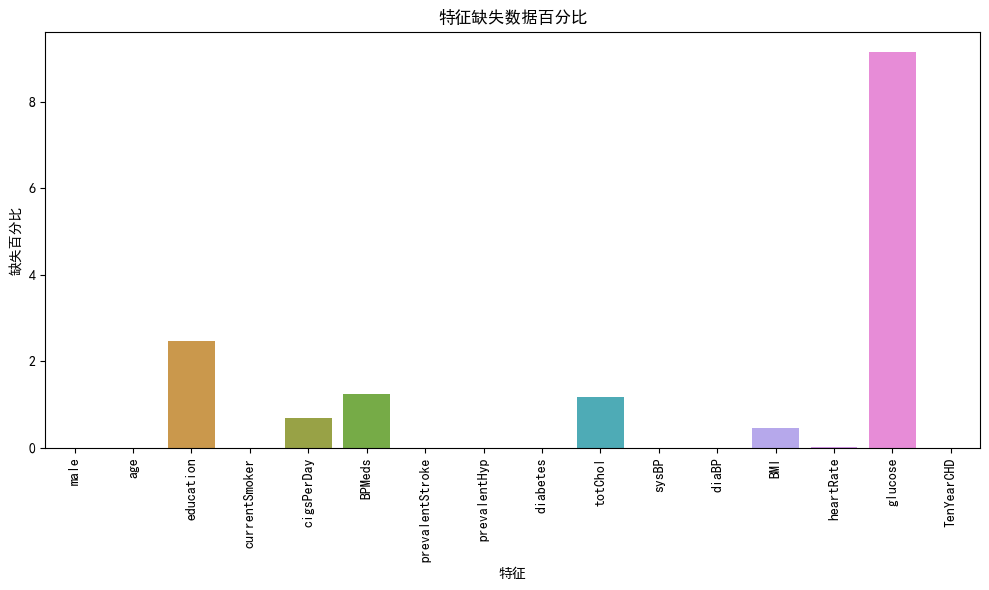

处理缺失值后的数据形状: (3658, 16)


In [3]:
# 检查缺失值
missing_data = df.isnull().sum()
print("\n缺失数据:")
print(missing_data)

# 计算每个特征的缺失数据百分比
missing_data = missing_data.to_frame(name='Total')
missing_data['Percentage'] = (missing_data['Total'] / len(df)) * 100

# 可视化缺失数据
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data['Percentage'])
plt.title("特征缺失数据百分比")
plt.xlabel("特征")
plt.ylabel("缺失百分比")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 处理缺失值 - 直接删除含有缺失值的行
df.dropna(axis=0, inplace=True)
print(f"处理缺失值后的数据形状: {df.shape}")


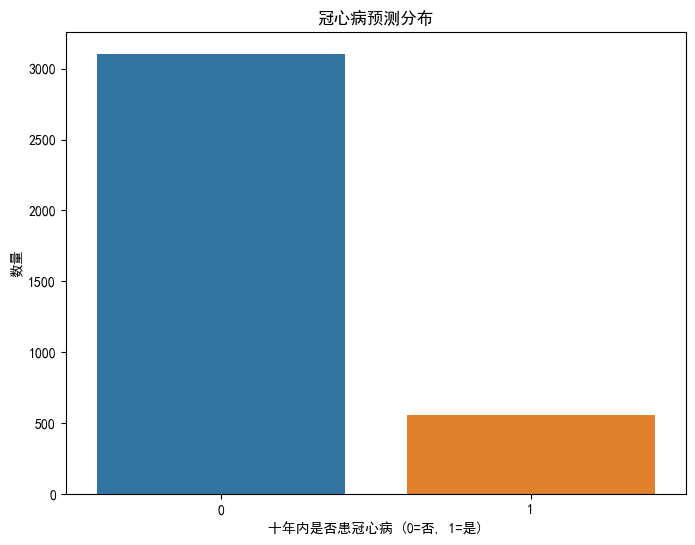

没有心脏病的患者有 3101 人，有心脏病的患者有 557 人
阳性:阴性比例 = 1:5.57


In [4]:
# 目标变量分布
plt.figure(figsize=(8, 6))
sns.countplot(x="TenYearCHD", data=df)
plt.title("冠心病预测分布")
plt.xlabel("十年内是否患冠心病 (0=否, 1=是)")
plt.ylabel("数量")
plt.show()

cases = df.TenYearCHD.value_counts()
print(f"没有心脏病的患者有 {cases[0]} 人，有心脏病的患者有 {cases[1]} 人")
print(f"阳性:阴性比例 = 1:{cases[0]/cases[1]:.2f}")


<Figure size 1500x1500 with 0 Axes>

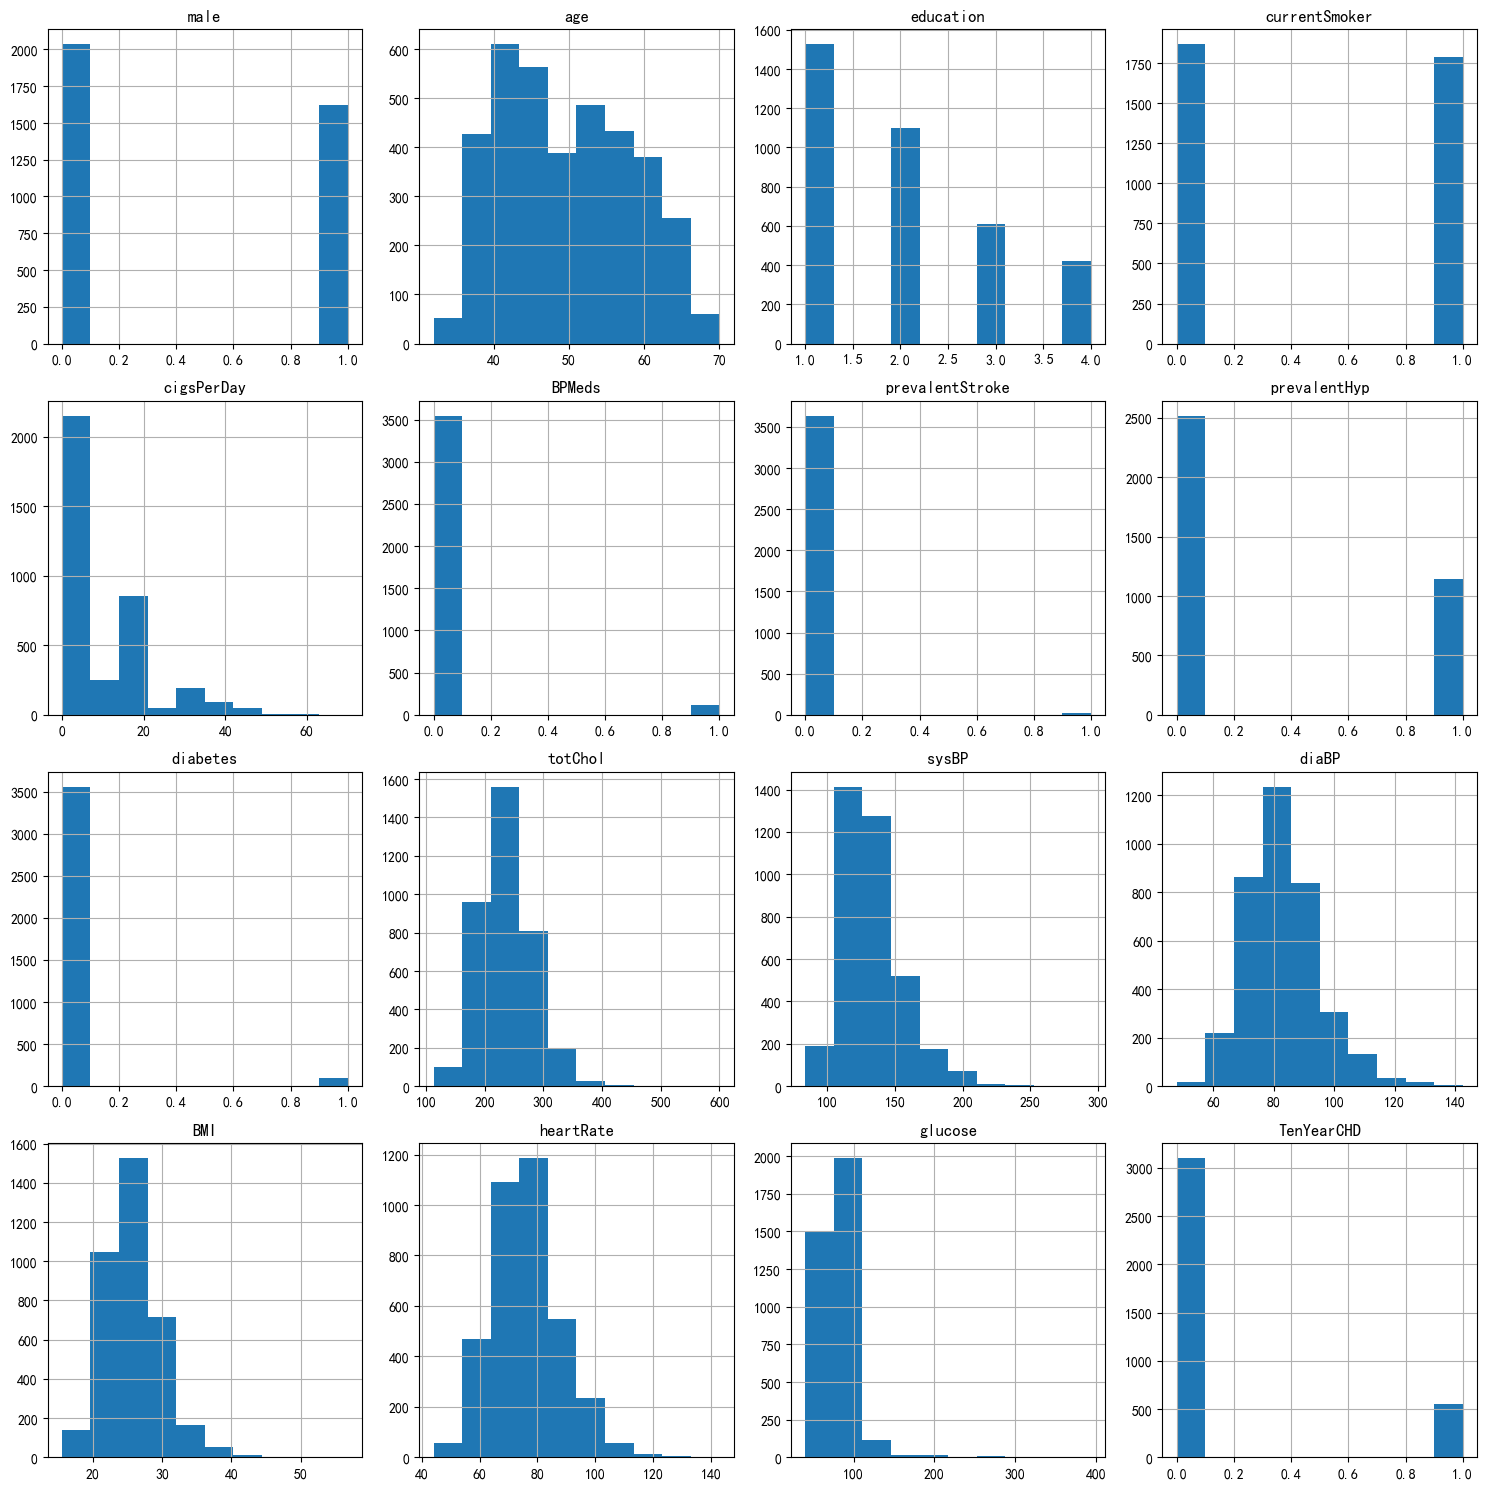

In [5]:
# 数据分布可视化
plt.figure(figsize=(15, 15))
df.hist(figsize=(15, 15))
plt.tight_layout()
plt.show()


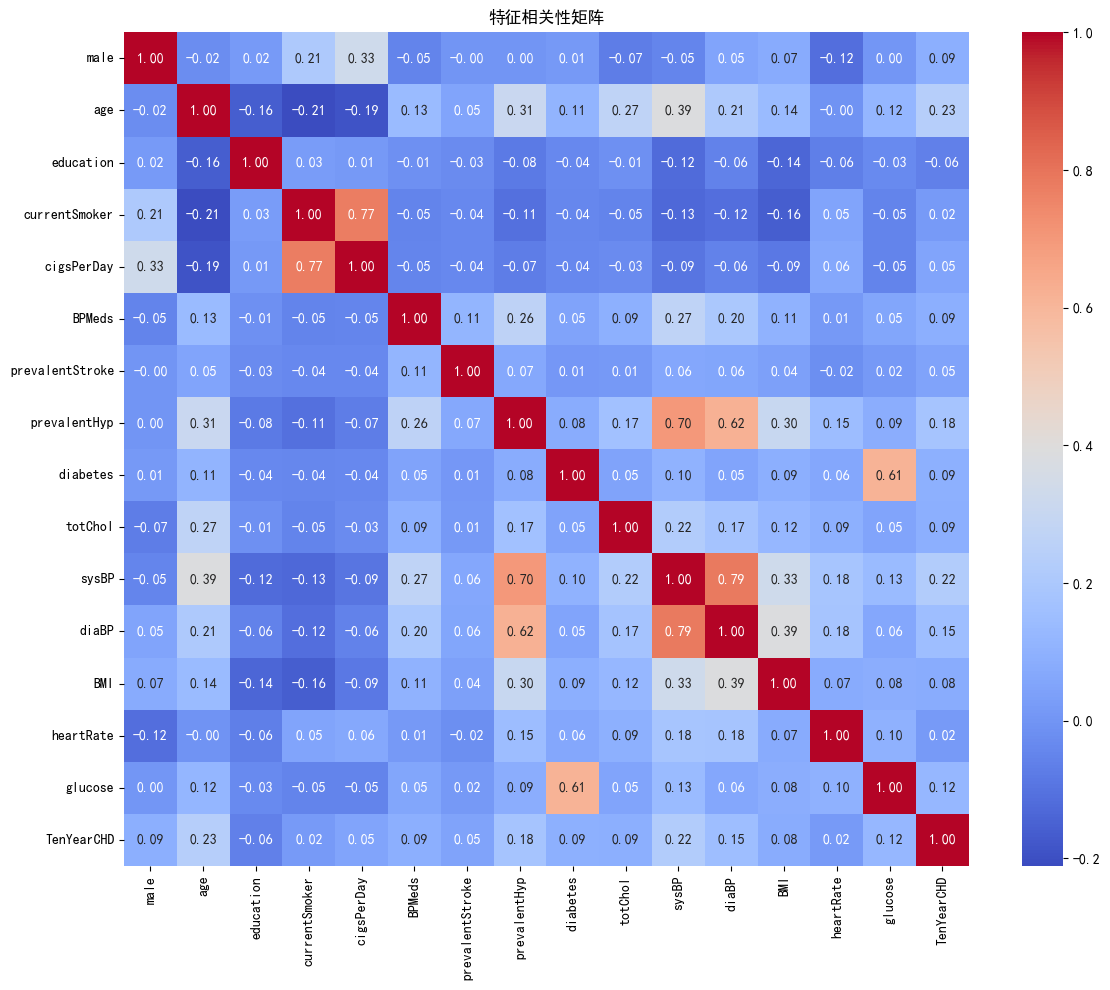

In [6]:
# 相关性分析
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("特征相关性矩阵")
plt.tight_layout()
plt.show()

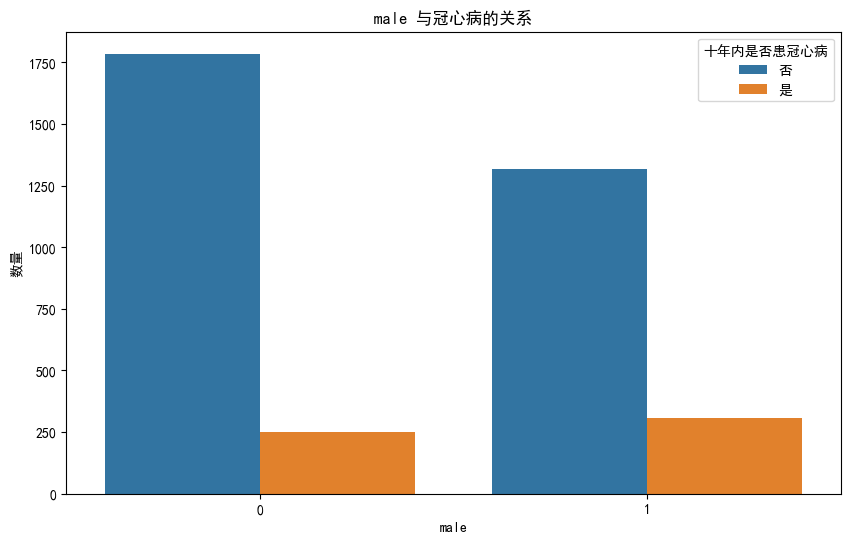

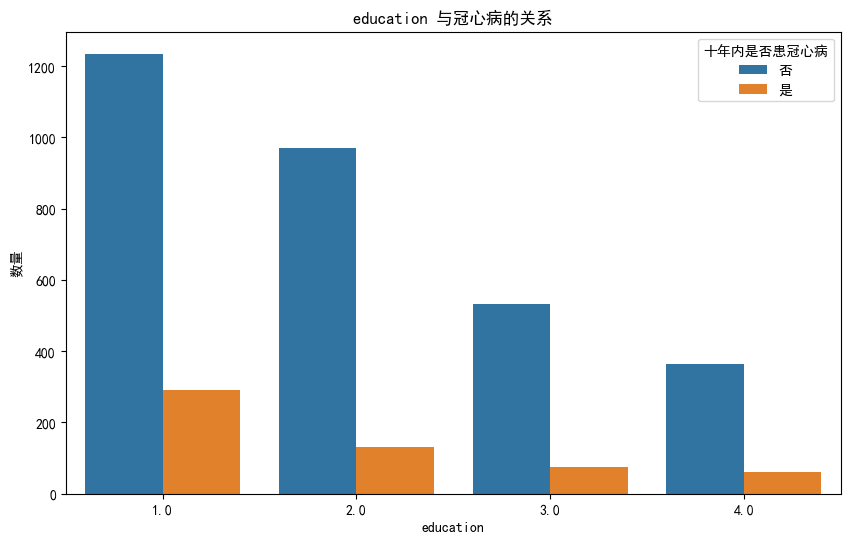

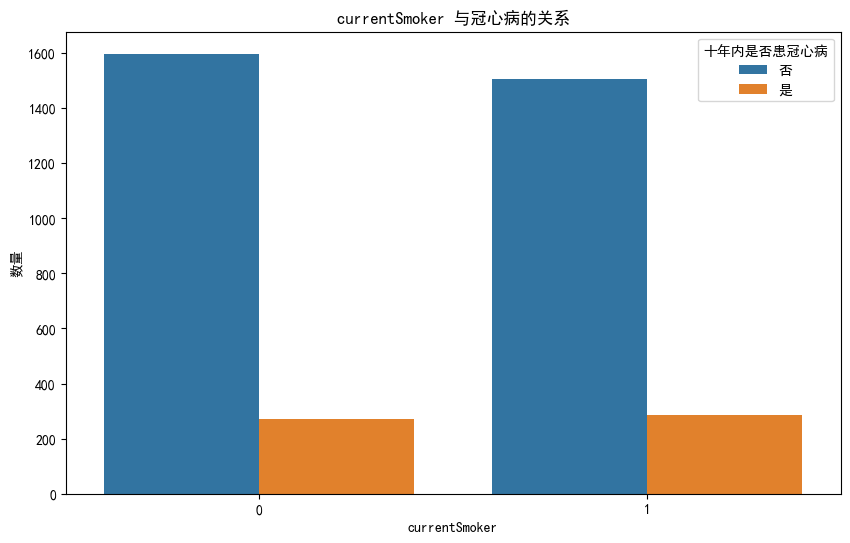

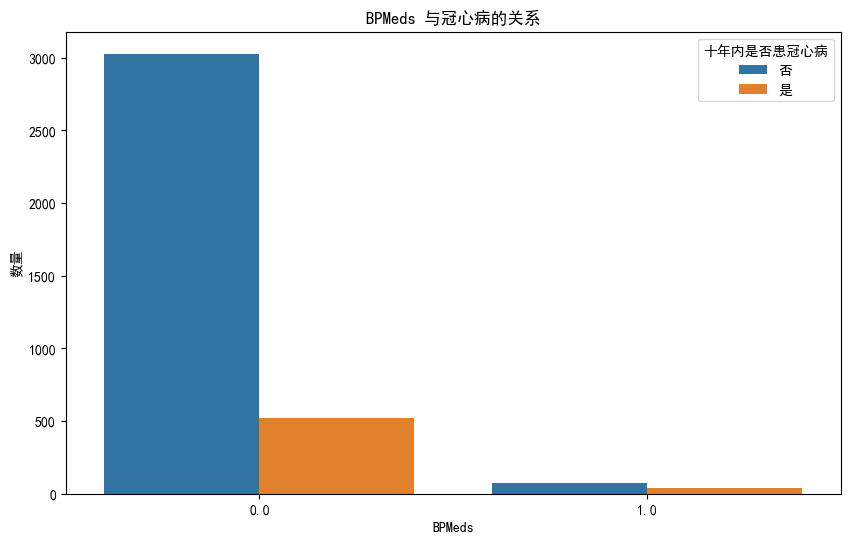

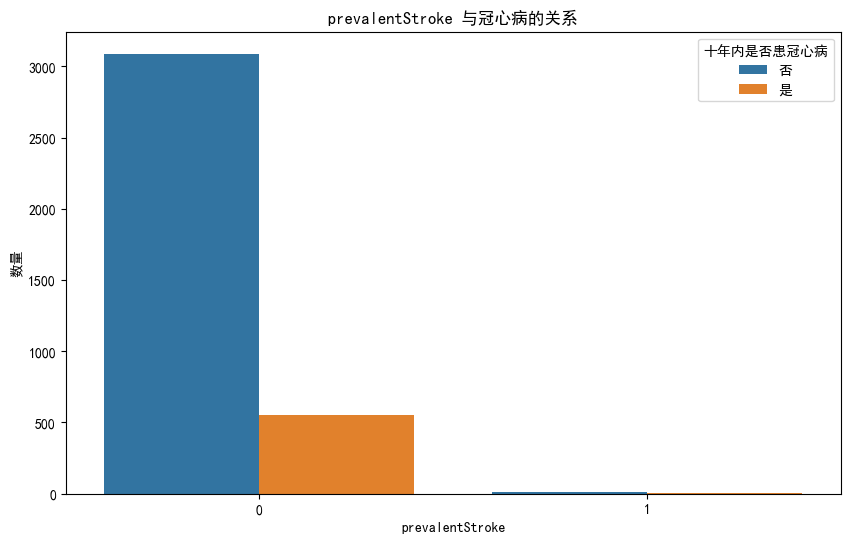

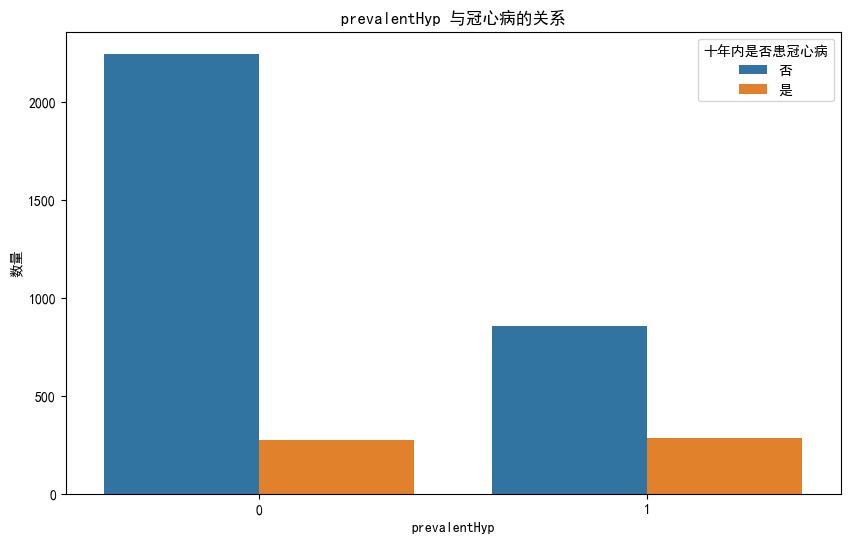

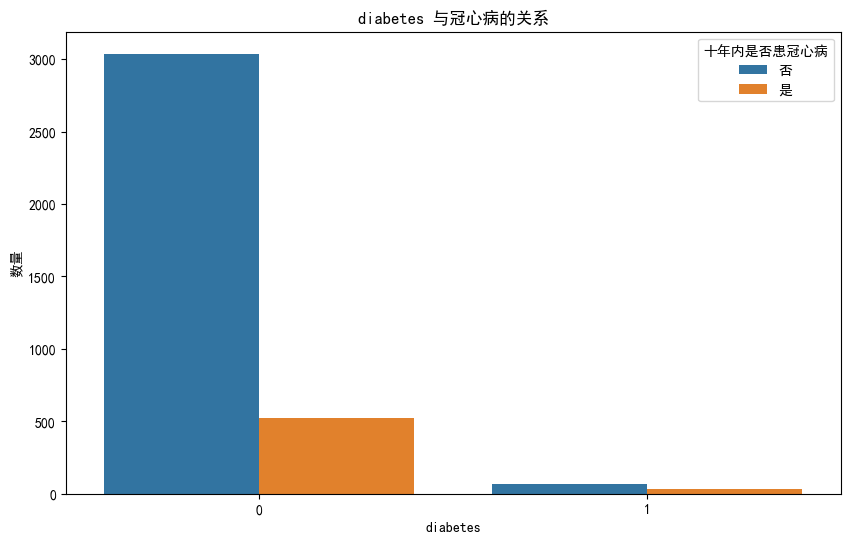

In [7]:
# 分类特征的可视化
categorical_features = ['male', 'education', 'currentSmoker', 'BPMeds', 
                       'prevalentStroke', 'prevalentHyp', 'diabetes']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue="TenYearCHD", data=df)
    plt.title(f"{feature} 与冠心病的关系")
    plt.xlabel(feature)
    plt.ylabel("数量")
    plt.legend(title="十年内是否患冠心病", labels=["否", "是"])
    plt.show()
    

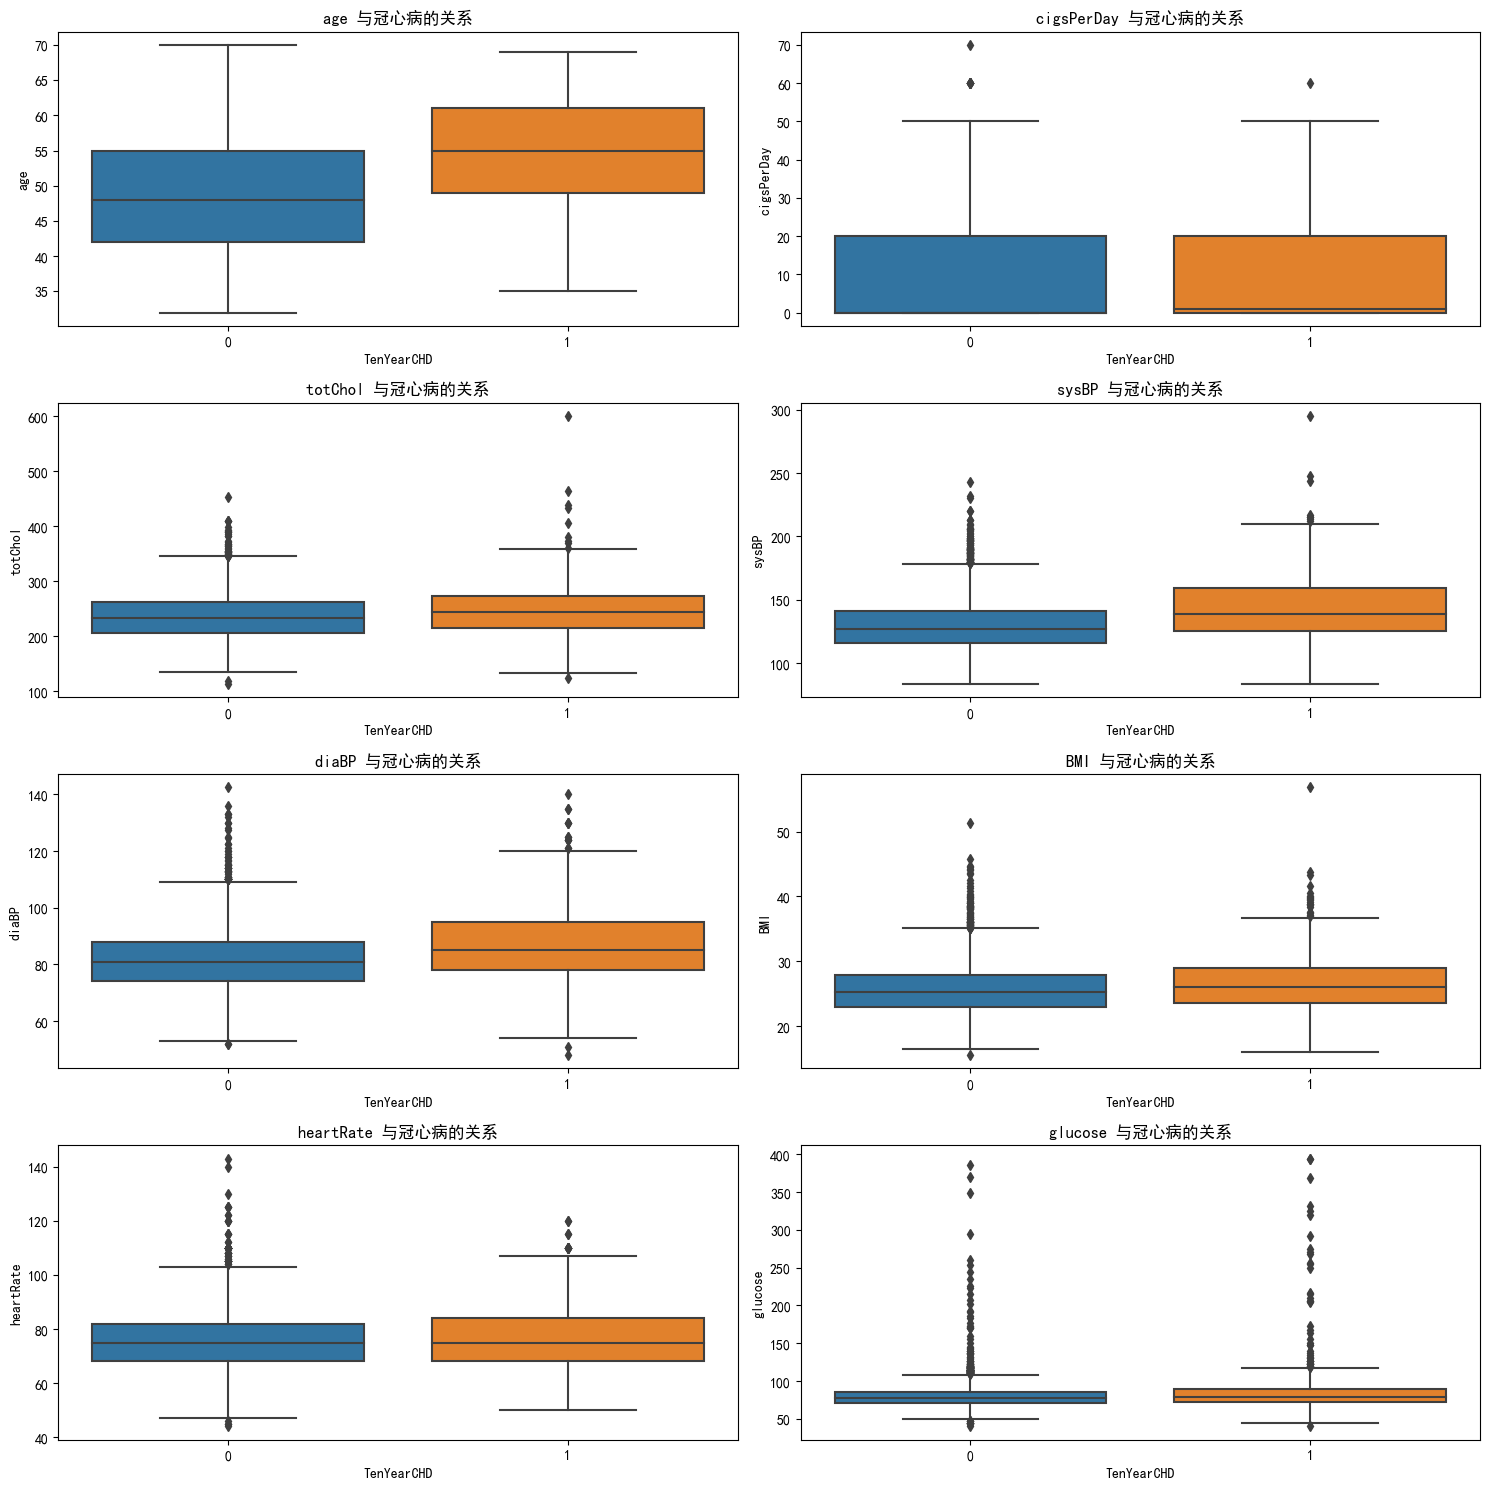

In [8]:
# 数值特征的可视化
numeric_features = ["age", "cigsPerDay", "totChol", "sysBP", "diaBP", 
                   "BMI", "heartRate", "glucose"]

# 箱线图
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x="TenYearCHD", y=feature, data=df)
    plt.title(f"{feature} 与冠心病的关系")
plt.tight_layout()
plt.show()



卡方检验 p 值:
prevalentHyp       8.872601e-20
diabetes           2.491938e-08
BPMeds             1.098822e-07
male               3.531788e-05
prevalentStroke    3.536210e-03
education          5.421198e-03
currentSmoker      4.073664e-01
dtype: float64


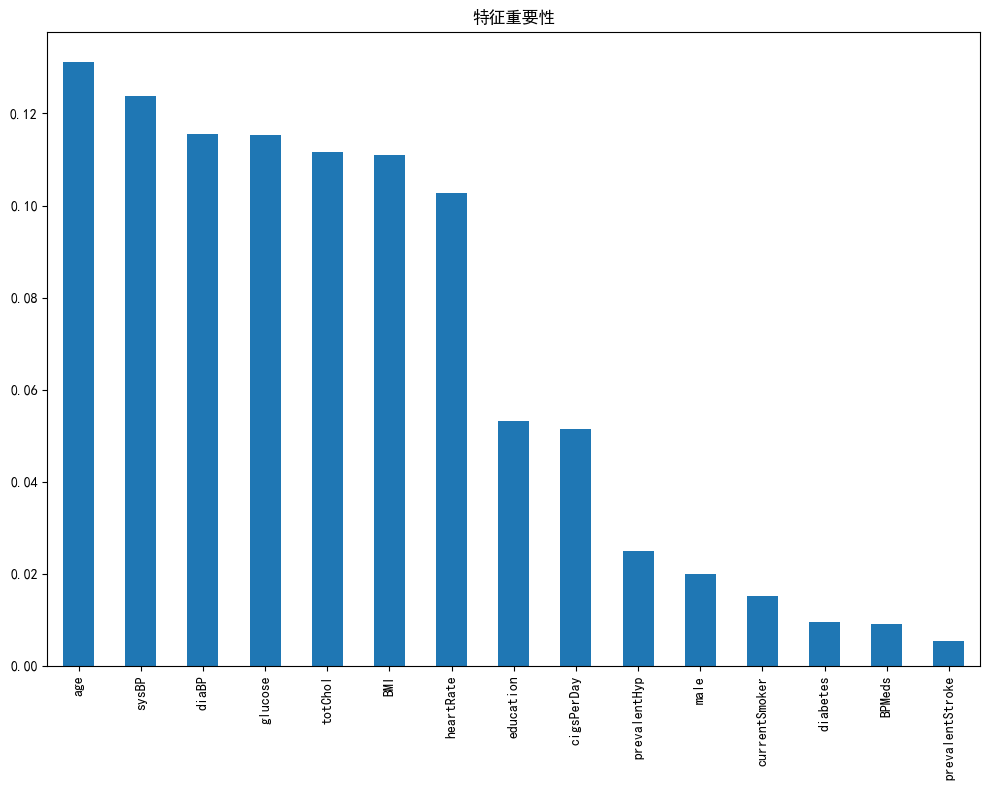

In [9]:
# 特征选择与工程
# 使用卡方检验选择分类特征
from sklearn.feature_selection import chi2, SelectKBest

X_cat = df[categorical_features]
y = df['TenYearCHD']

chi_scores = chi2(X_cat, y)
p_values = pd.Series(chi_scores[1], index=X_cat.columns)
print("\n卡方检验 p 值:")
print(p_values.sort_values())

# 使用随机森林评估特征重要性
X = df.drop('TenYearCHD', axis=1)
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 8))
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title("特征重要性")
plt.tight_layout()
plt.show()



重采样前的类别分布:
Counter({0: 3101, 1: 557})

重采样后的类别分布:
Counter({0: 3100, 1: 2480})


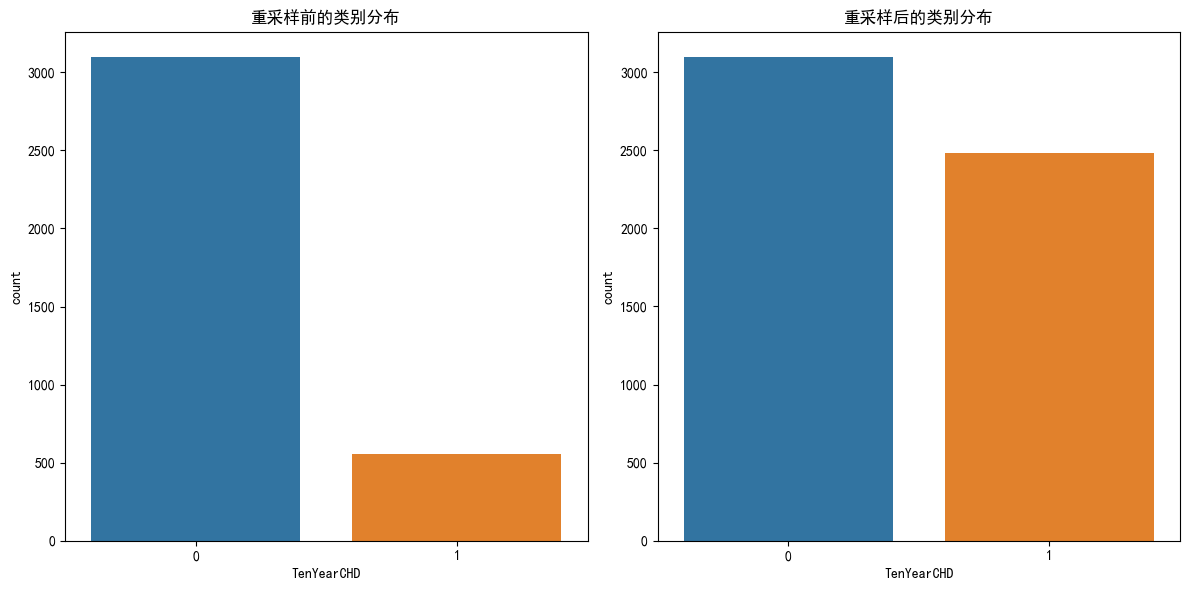

In [10]:
# 数据准备
# 拆分特征和目标变量
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

# 应用SMOTE来平衡数据
# 定义重采样策略
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [("o", over), ("u", under)]
pipeline = Pipeline(steps=steps)

# 应用重采样
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# 显示重采样前后的类别分布
print("\n重采样前的类别分布:")
print(Counter(y))
print("\n重采样后的类别分布:")
print(Counter(y_resampled))

# 可视化重采样前后的类别分布
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title("重采样前的类别分布")
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled)
plt.title("重采样后的类别分布")
plt.tight_layout()
plt.show()

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 转换回DataFrame以保留列名
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)


### 逻辑回归模型

=============== 逻辑回归模型 ===============
最佳参数: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
准确率: 0.6971
F1分数: 0.6508
AUC: 0.7517

混淆矩阵:
[[463 163]
 [175 315]]

分类报告:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       626
           1       0.66      0.64      0.65       490

    accuracy                           0.70      1116
   macro avg       0.69      0.69      0.69      1116
weighted avg       0.70      0.70      0.70      1116



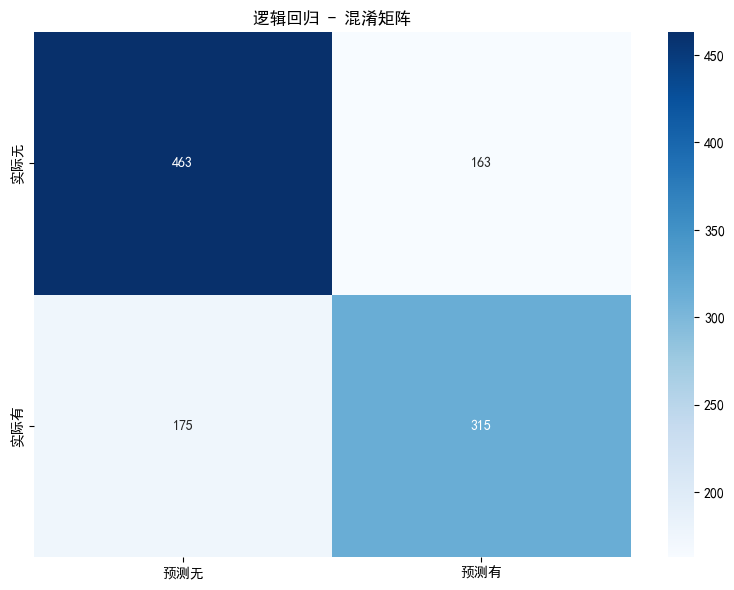

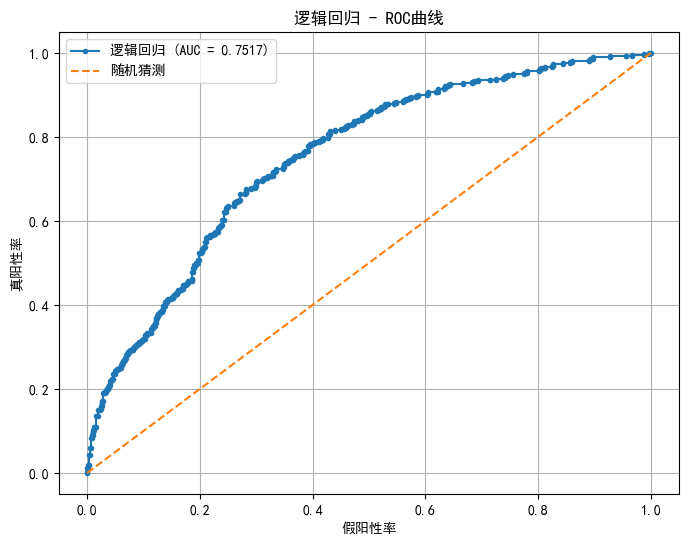

In [11]:
# 逻辑回归模型训练与评估
print("=============== 逻辑回归模型 ===============")
# 定义参数网格
lr_params = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['liblinear']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring='f1')

# 训练模型
lr_grid.fit(X_train, y_train)
print(f"最佳参数: {lr_grid.best_params_}")

# 在测试集上评估
lr_pred = lr_grid.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_proba = lr_grid.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_proba)

print(f"准确率: {lr_accuracy:.4f}")
print(f"F1分数: {lr_f1:.4f}")
print(f"AUC: {lr_auc:.4f}")

# 混淆矩阵
lr_cm = confusion_matrix(y_test, lr_pred)
print("\n混淆矩阵:")
print(lr_cm)

# 分类报告
print("\n分类报告:")
print(classification_report(y_test, lr_pred))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测无', '预测有'],
            yticklabels=['实际无', '实际有'])
plt.title('逻辑回归 - 混淆矩阵')
plt.tight_layout()
plt.show()

# 绘制ROC曲线
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba)
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, marker='.', label=f'逻辑回归 (AUC = {lr_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('逻辑回归 - ROC曲线')
plt.legend()
plt.grid(True)
plt.show()


### K-最近邻模型

=============== K近邻模型 ===============
最佳参数: {'n_neighbors': 3}
准确率: 0.7527
F1分数: 0.7518
AUC: 0.8308

混淆矩阵:
[[422 204]
 [ 72 418]]

分类报告:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       626
           1       0.67      0.85      0.75       490

    accuracy                           0.75      1116
   macro avg       0.76      0.76      0.75      1116
weighted avg       0.77      0.75      0.75      1116



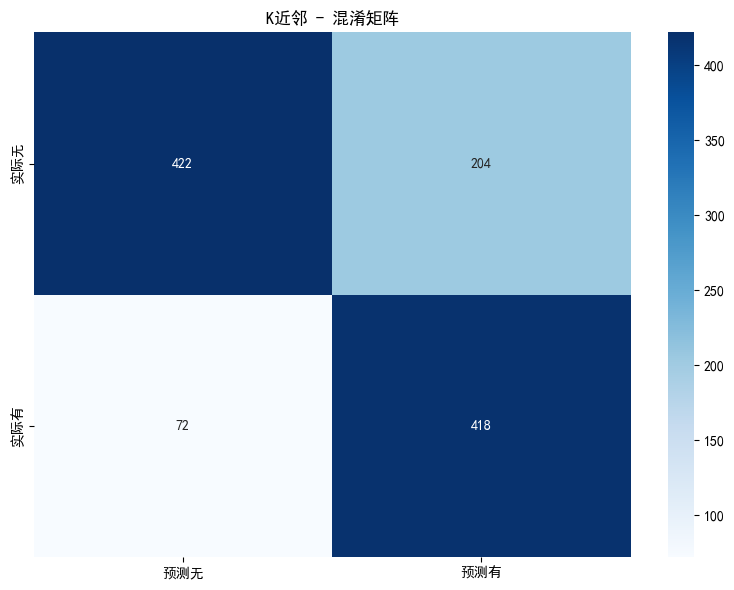

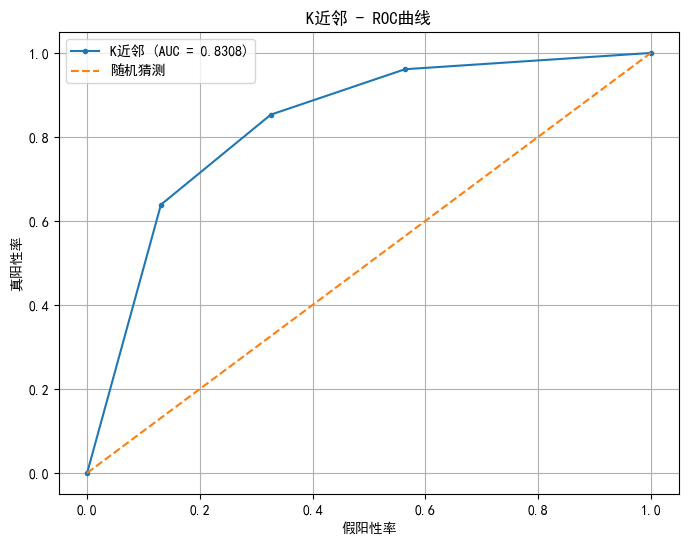

In [12]:
# K近邻模型训练与评估
print("=============== K近邻模型 ===============")
# 定义参数网格
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1')

# 训练模型
knn_grid.fit(X_train, y_train)
print(f"最佳参数: {knn_grid.best_params_}")

# 在测试集上评估
knn_pred = knn_grid.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_proba = knn_grid.predict_proba(X_test)[:, 1]
knn_auc = roc_auc_score(y_test, knn_proba)

print(f"准确率: {knn_accuracy:.4f}")
print(f"F1分数: {knn_f1:.4f}")
print(f"AUC: {knn_auc:.4f}")

# 混淆矩阵
knn_cm = confusion_matrix(y_test, knn_pred)
print("\n混淆矩阵:")
print(knn_cm)

# 分类报告
print("\n分类报告:")
print(classification_report(y_test, knn_pred))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测无', '预测有'],
            yticklabels=['实际无', '实际有'])
plt.title('K近邻 - 混淆矩阵')
plt.tight_layout()
plt.show()

# 绘制ROC曲线
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_proba)
plt.figure(figsize=(8, 6))
plt.plot(knn_fpr, knn_tpr, marker='.', label=f'K近邻 (AUC = {knn_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('K近邻 - ROC曲线')
plt.legend()
plt.grid(True)
plt.show()


### 决策树模型

=============== 决策树模型 ===============
最佳参数: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
准确率: 0.8199
F1分数: 0.8012
AUC: 0.8206

混淆矩阵:
[[510 116]
 [ 85 405]]

分类报告:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       626
           1       0.78      0.83      0.80       490

    accuracy                           0.82      1116
   macro avg       0.82      0.82      0.82      1116
weighted avg       0.82      0.82      0.82      1116



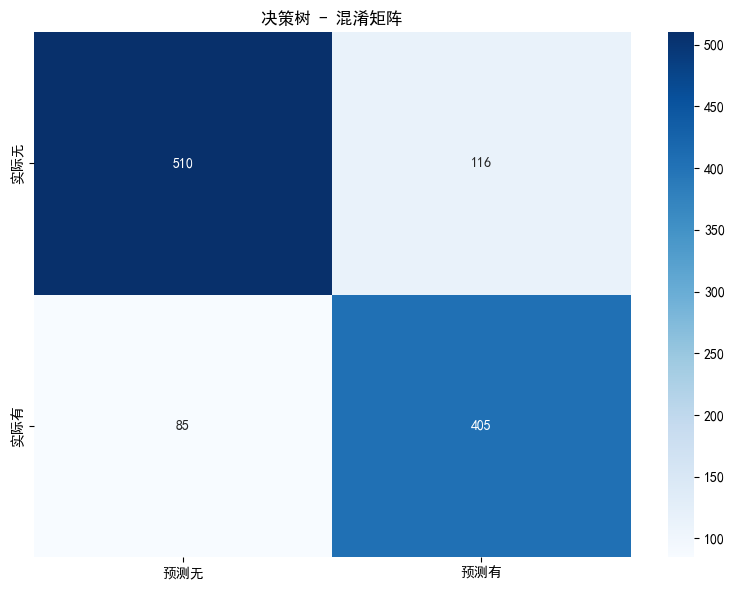

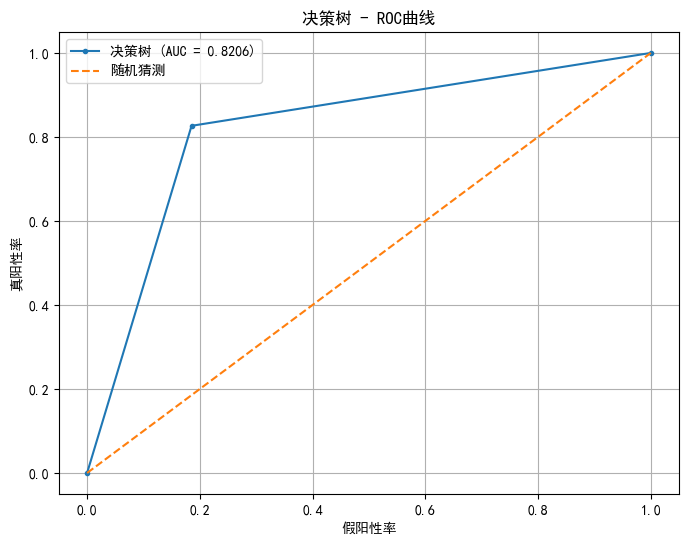

In [13]:
# 决策树模型训练与评估
print("=============== 决策树模型 ===============")
# 定义参数网格
dt_params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='f1')

# 训练模型
dt_grid.fit(X_train, y_train)
print(f"最佳参数: {dt_grid.best_params_}")

# 在测试集上评估
dt_pred = dt_grid.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_proba = dt_grid.predict_proba(X_test)[:, 1]
dt_auc = roc_auc_score(y_test, dt_proba)

print(f"准确率: {dt_accuracy:.4f}")
print(f"F1分数: {dt_f1:.4f}")
print(f"AUC: {dt_auc:.4f}")

# 混淆矩阵
dt_cm = confusion_matrix(y_test, dt_pred)
print("\n混淆矩阵:")
print(dt_cm)

# 分类报告
print("\n分类报告:")
print(classification_report(y_test, dt_pred))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测无', '预测有'],
            yticklabels=['实际无', '实际有'])
plt.title('决策树 - 混淆矩阵')
plt.tight_layout()
plt.show()

# 绘制ROC曲线
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba)
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, marker='.', label=f'决策树 (AUC = {dt_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('决策树 - ROC曲线')
plt.legend()
plt.grid(True)
plt.show()


### 支持向量机模型

=============== 支持向量机模型 ===============
最佳参数: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
准确率: 0.8280
F1分数: 0.8021
AUC: 0.9085

混淆矩阵:
[[535  91]
 [101 389]]

分类报告:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       626
           1       0.81      0.79      0.80       490

    accuracy                           0.83      1116
   macro avg       0.83      0.82      0.82      1116
weighted avg       0.83      0.83      0.83      1116



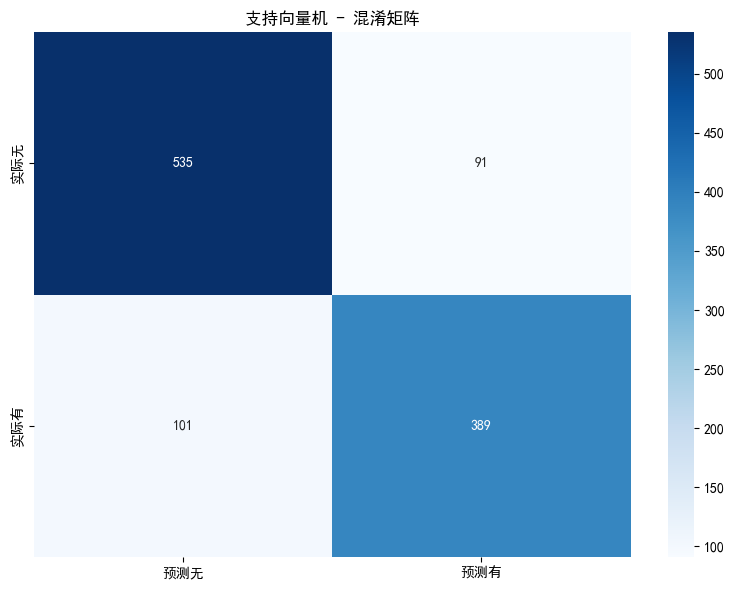

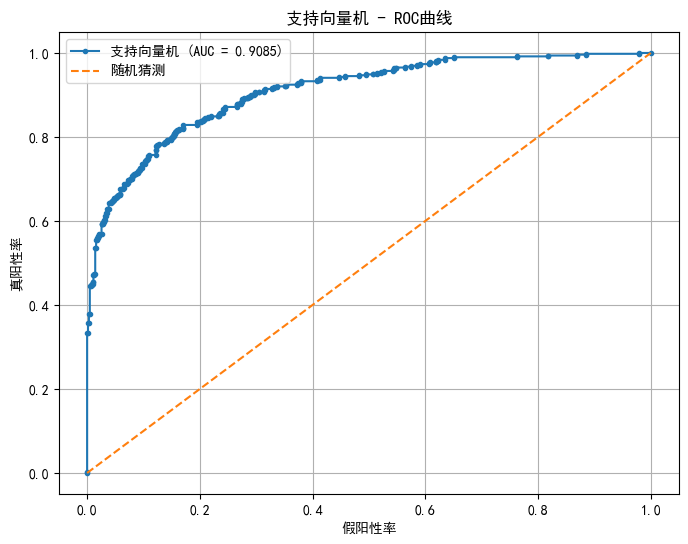

In [14]:
# 支持向量机模型训练与评估
print("=============== 支持向量机模型 ===============")
# 定义参数网格
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='f1')

# 训练模型
svm_grid.fit(X_train, y_train)
print(f"最佳参数: {svm_grid.best_params_}")

# 在测试集上评估
svm_pred = svm_grid.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_proba = svm_grid.predict_proba(X_test)[:, 1]
svm_auc = roc_auc_score(y_test, svm_proba)

print(f"准确率: {svm_accuracy:.4f}")
print(f"F1分数: {svm_f1:.4f}")
print(f"AUC: {svm_auc:.4f}")

# 混淆矩阵
svm_cm = confusion_matrix(y_test, svm_pred)
print("\n混淆矩阵:")
print(svm_cm)

# 分类报告
print("\n分类报告:")
print(classification_report(y_test, svm_pred))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测无', '预测有'],
            yticklabels=['实际无', '实际有'])
plt.title('支持向量机 - 混淆矩阵')
plt.tight_layout()
plt.show()

# 绘制ROC曲线
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_proba)
plt.figure(figsize=(8, 6))
plt.plot(svm_fpr, svm_tpr, marker='.', label=f'支持向量机 (AUC = {svm_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('支持向量机 - ROC曲线')
plt.legend()
plt.grid(True)
plt.show()


### 随机森林模型

=============== 随机森林模型 ===============
最佳参数: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
准确率: 0.8987
F1分数: 0.8804
AUC: 0.9615

混淆矩阵:
[[587  39]
 [ 74 416]]

分类报告:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       626
           1       0.91      0.85      0.88       490

    accuracy                           0.90      1116
   macro avg       0.90      0.89      0.90      1116
weighted avg       0.90      0.90      0.90      1116



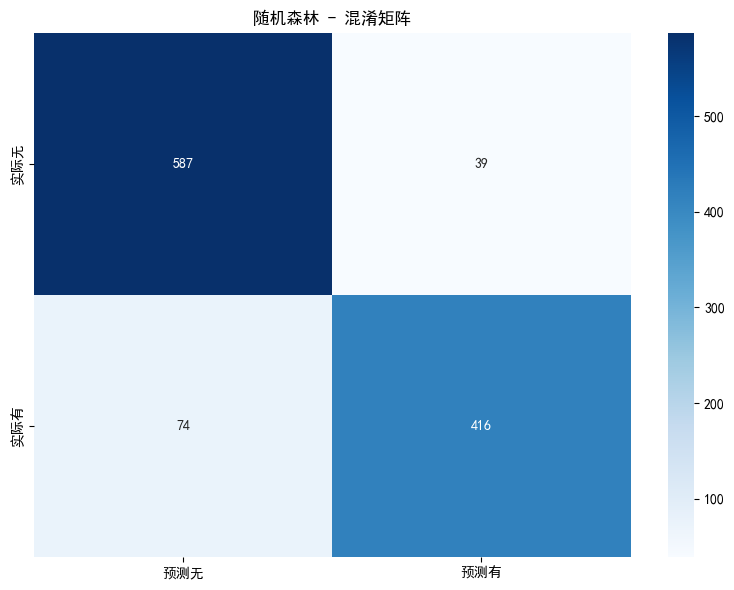

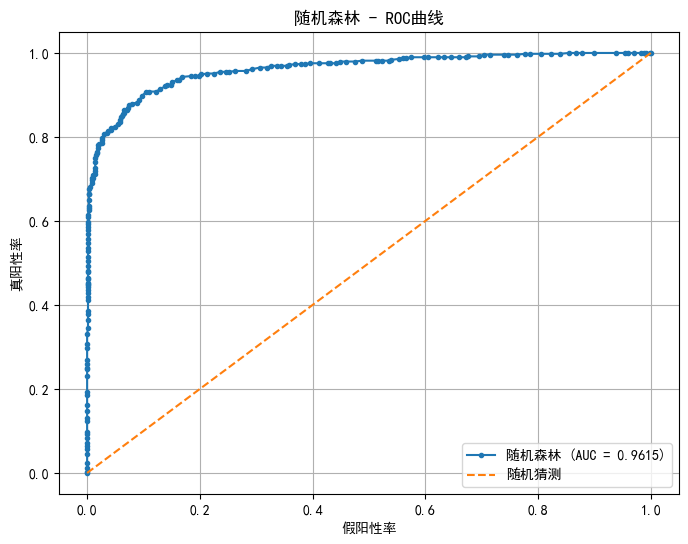

In [15]:
# 随机森林模型训练与评估
print("=============== 随机森林模型 ===============")
# 定义参数网格
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1')

# 训练模型
rf_grid.fit(X_train, y_train)
print(f"最佳参数: {rf_grid.best_params_}")

# 在测试集上评估
rf_pred = rf_grid.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_proba = rf_grid.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_proba)

print(f"准确率: {rf_accuracy:.4f}")
print(f"F1分数: {rf_f1:.4f}")
print(f"AUC: {rf_auc:.4f}")

# 混淆矩阵
rf_cm = confusion_matrix(y_test, rf_pred)
print("\n混淆矩阵:")
print(rf_cm)

# 分类报告
print("\n分类报告:")
print(classification_report(y_test, rf_pred))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测无', '预测有'],
            yticklabels=['实际无', '实际有'])
plt.title('随机森林 - 混淆矩阵')
plt.tight_layout()
plt.show()

# 绘制ROC曲线
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, marker='.', label=f'随机森林 (AUC = {rf_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('随机森林 - ROC曲线')
plt.legend()
plt.grid(True)
plt.show()


### 传统模型比较


传统模型比较：
       accuracy        f1       auc
随机森林   0.898746  0.880423  0.961462
支持向量机  0.827957  0.802062  0.908468
K-最近邻  0.752688  0.751799  0.830772
决策树    0.819892  0.801187  0.820614
逻辑回归   0.697133  0.650826  0.751734


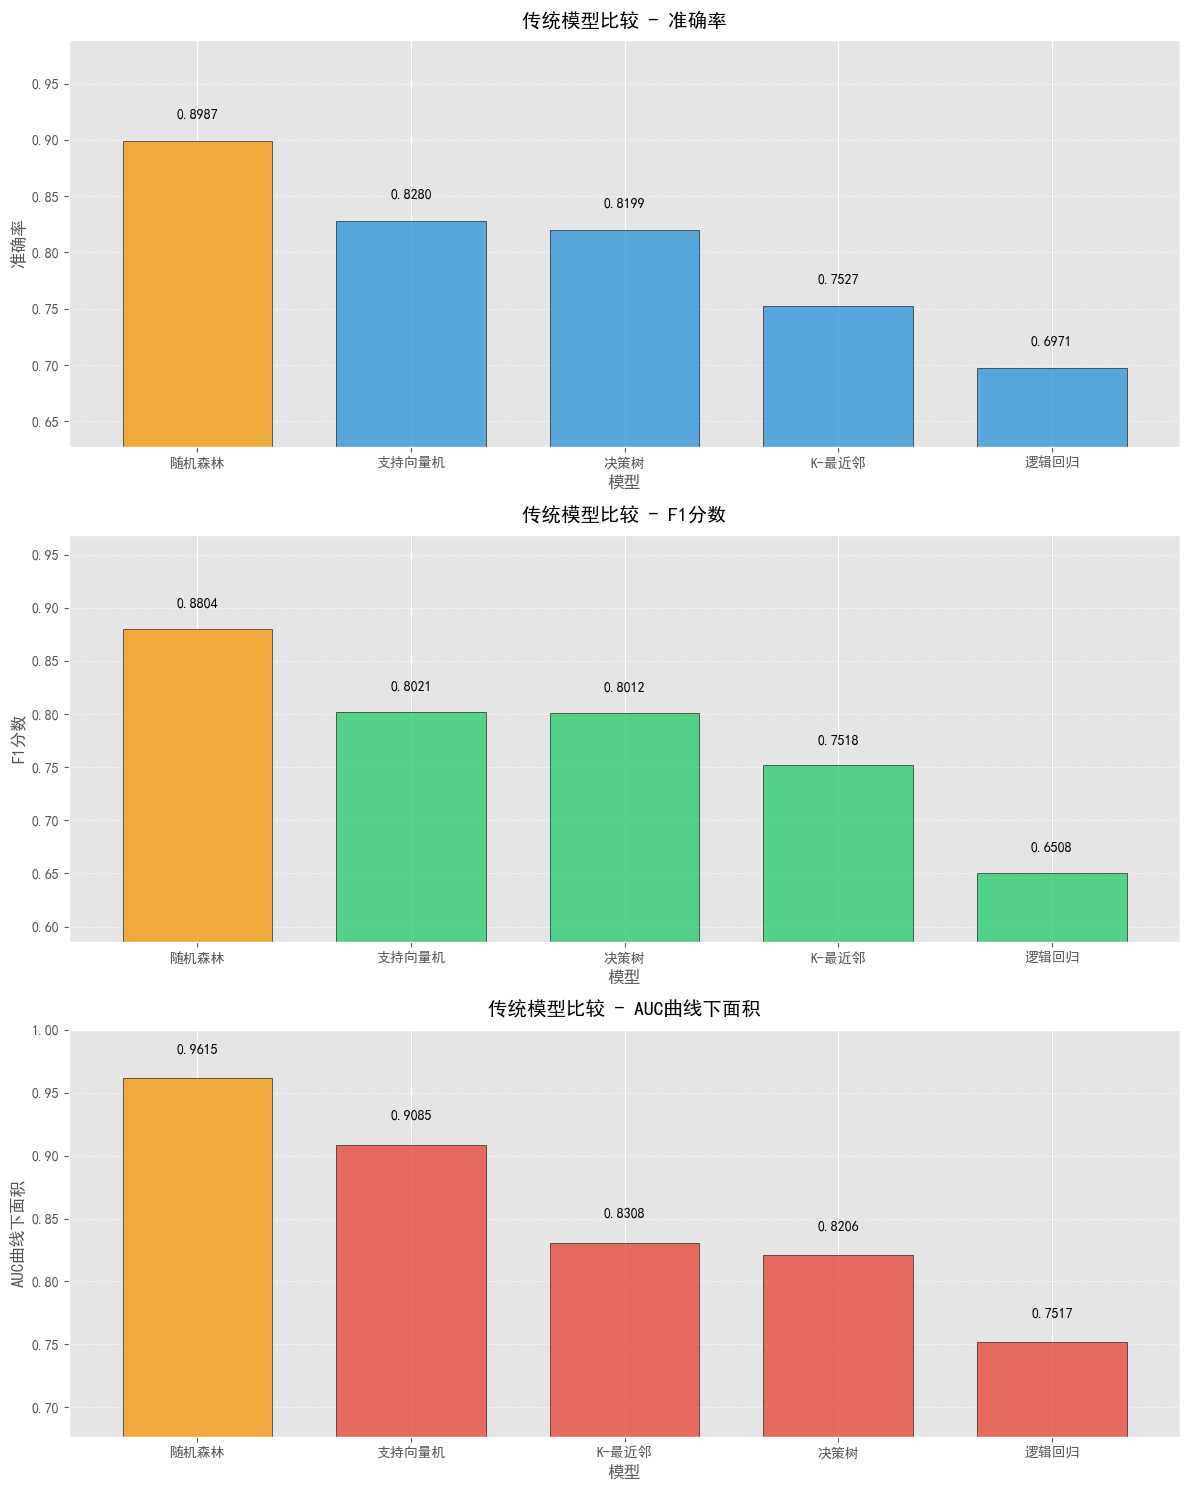

In [16]:
# 传统模型性能比较
traditional_results = {
    "逻辑回归": {'accuracy': lr_accuracy, 'f1': lr_f1, 'auc': lr_auc},
    "K-最近邻": {'accuracy': knn_accuracy, 'f1': knn_f1, 'auc': knn_auc},
    "决策树": {'accuracy': dt_accuracy, 'f1': dt_f1, 'auc': dt_auc},
    "支持向量机": {'accuracy': svm_accuracy, 'f1': svm_f1, 'auc': svm_auc},
    "随机森林": {'accuracy': rf_accuracy, 'f1': rf_f1, 'auc': rf_auc}
}

# 创建比较DataFrame
trad_df = pd.DataFrame(traditional_results).T
trad_df = trad_df.sort_values(by="auc", ascending=False)
print("\n传统模型比较：")
print(trad_df)

# 确保中文显示正常
import matplotlib as mpl
# 尝试设置中文字体，如果出错就使用英文标签
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
    use_chinese = True
except:
    use_chinese = False
    
# 可视化模型比较 - 使用更好看的样式
plt.style.use('ggplot')  # 使用ggplot风格
metrics = ['accuracy', 'f1', 'auc']
metric_labels = {
    'accuracy': 'Accuracy (准确率)' if not use_chinese else '准确率',
    'f1': 'F1 Score (F1分数)' if not use_chinese else 'F1分数', 
    'auc': 'AUC' if not use_chinese else 'AUC曲线下面积'
}
model_title = 'Traditional Models Comparison' if not use_chinese else '传统模型比较'
colors = ['#3498db', '#2ecc71', '#e74c3c']  # 好看的颜色

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 15))

for i, metric in enumerate(metrics):
    # 按指标排序
    sorted_data = trad_df.sort_values(by=metric, ascending=False)
    
    # 创建柱状图
    bars = sorted_data[metric].plot(
        kind='bar', 
        ax=axes[i], 
        color=colors[i],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.8,
        width=0.7
    )
    
    # 设置标题和标签
    axes[i].set_title(f'{model_title} - {metric_labels[metric]}', fontsize=14, pad=10)
    axes[i].set_xlabel('Models (模型)' if not use_chinese else '模型', fontsize=12)
    axes[i].set_ylabel(metric_labels[metric], fontsize=12)
    
    # 设置y轴范围，使数据更突出
    y_min = max(0, min(sorted_data[metric]) * 0.9)
    y_max = min(1.0, max(sorted_data[metric]) * 1.1)
    axes[i].set_ylim(y_min, y_max)
    
    # 添加数值标签
    for j, v in enumerate(sorted_data[metric]):
        axes[i].text(
            j, 
            v + 0.02, 
            f'{v:.4f}', 
            ha='center',
            fontsize=10,
            fontweight='bold'
        )
    
    # 突出显示最佳模型
    best_model_idx = sorted_data[metric].idxmax()
    best_model_pos = sorted_data.index.get_loc(best_model_idx)
    bars.patches[best_model_pos].set_facecolor('#f39c12')  # 最佳模型用橙色
    
    # 改进网格线显示
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    
    # 旋转x轴标签使其更易读
    plt.setp(axes[i].get_xticklabels(), rotation=0, ha='center')

# 调整布局
plt.tight_layout()
plt.show()


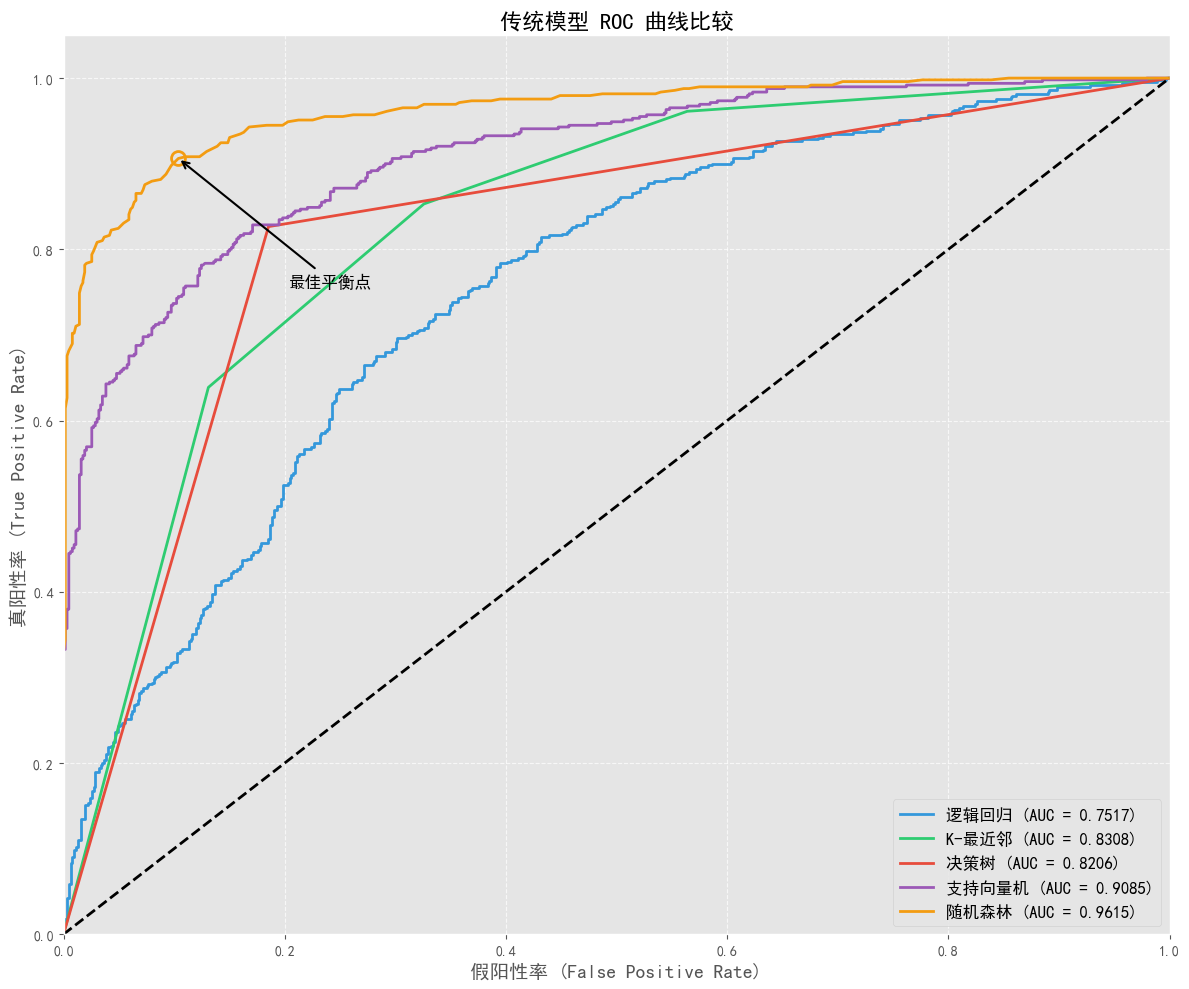

In [35]:
# 绘制传统模型的ROC曲线比较
plt.figure(figsize=(12, 10))

# 设置颜色方案
color_dict = {
    "逻辑回归": '#3498db',     # 蓝色
    "K-最近邻": '#2ecc71',     # 绿色
    "决策树": '#e74c3c',       # 红色
    "支持向量机": '#9b59b6',   # 紫色
    "随机森林": '#f39c12'      # 橙色
}

# 绘制每个模型的ROC曲线
plt.plot(lr_fpr, lr_tpr, color=color_dict["逻辑回归"], lw=2, 
         label=f'逻辑回归 (AUC = {lr_auc:.4f})')
plt.plot(knn_fpr, knn_tpr, color=color_dict["K-最近邻"], lw=2, 
         label=f'K-最近邻 (AUC = {knn_auc:.4f})')
plt.plot(dt_fpr, dt_tpr, color=color_dict["决策树"], lw=2, 
         label=f'决策树 (AUC = {dt_auc:.4f})')
plt.plot(svm_fpr, svm_tpr, color=color_dict["支持向量机"], lw=2, 
         label=f'支持向量机 (AUC = {svm_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, color=color_dict["随机森林"], lw=2, 
         label=f'随机森林 (AUC = {rf_auc:.4f})')

# 添加对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 设置图表属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 (False Positive Rate)', fontsize=14)
plt.ylabel('真阳性率 (True Positive Rate)', fontsize=14)
plt.title('传统模型 ROC 曲线比较', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 在图上标出最佳模型的某个点
best_model = trad_df.index[0]  # 按AUC排序的第一个模型
if best_model == "随机森林":
    idx = np.argmax(rf_tpr - rf_fpr)
    x, y = rf_fpr[idx], rf_tpr[idx]
    plt.plot(x, y, 'o', markersize=10, fillstyle='none', 
             c=color_dict[best_model], mew=2)
    plt.annotate(f'最佳平衡点', 
                xy=(x, y), xytext=(x+0.1, y-0.15),
                arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
                fontsize=12, color='black')

plt.tight_layout()
plt.show()


### 模型评估函数

In [26]:
# 首先修改评估模型的函数，确保返回ROC曲线的数据
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    # 训练模型
    print(f"\n训练{model_name}...")
    model.fit(X_train, y_train)
    
    # 在测试集上评估
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 对于概率输出的模型
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        # 计算ROC曲线的值
        fpr, tpr, _ = roc_curve(y_test, y_proba)
    else:
        auc = 0.0
        fpr, tpr = None, None
    
    print(f"\n{model_name}模型评估结果:")
    print(f"准确率: {accuracy:.4f}")
    print(f"F1分数: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    print("\n混淆矩阵:")
    print(cm)
    
    # 分类报告
    print("\n分类报告:")
    print(classification_report(y_test, y_pred))
    
    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['预测无', '预测有'],
                yticklabels=['实际无', '实际有'])
    plt.title(f'{model_name} - 混淆矩阵')
    plt.tight_layout()
    plt.show()
    
    # 绘制ROC曲线
    if hasattr(model, "predict_proba"):
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, marker='.', label=f'{model_name} (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
        plt.xlabel('假阳性率')
        plt.ylabel('真阳性率')
        plt.title(f'{model_name} - ROC曲线')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # 返回包含ROC曲线数据的结果字典
    return {
        'accuracy': accuracy, 
        'f1': f1, 
        'auc': auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr
    }


### 投票分类器模型


=============== 投票分类器 ===============

训练投票分类器...

投票分类器模型评估结果:
准确率: 0.8584
F1分数: 0.8445
AUC: 0.9338

混淆矩阵:
[[529  97]
 [ 61 429]]

分类报告:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       626
           1       0.82      0.88      0.84       490

    accuracy                           0.86      1116
   macro avg       0.86      0.86      0.86      1116
weighted avg       0.86      0.86      0.86      1116



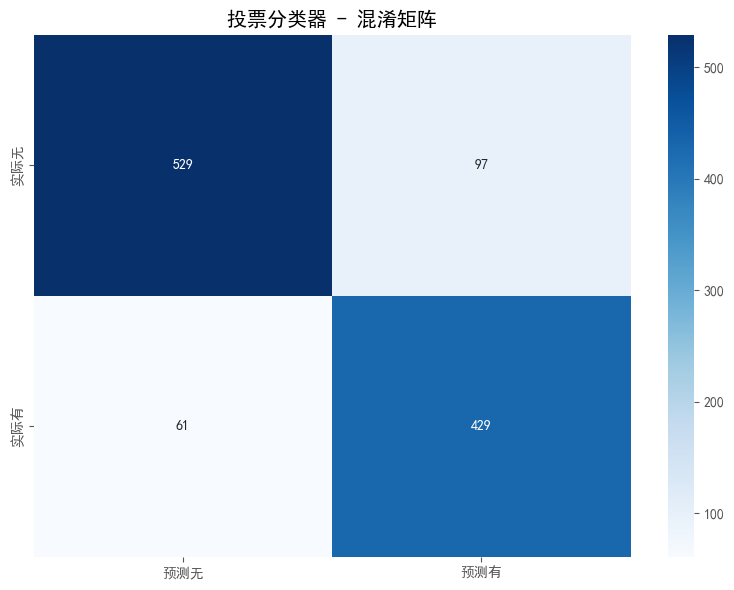

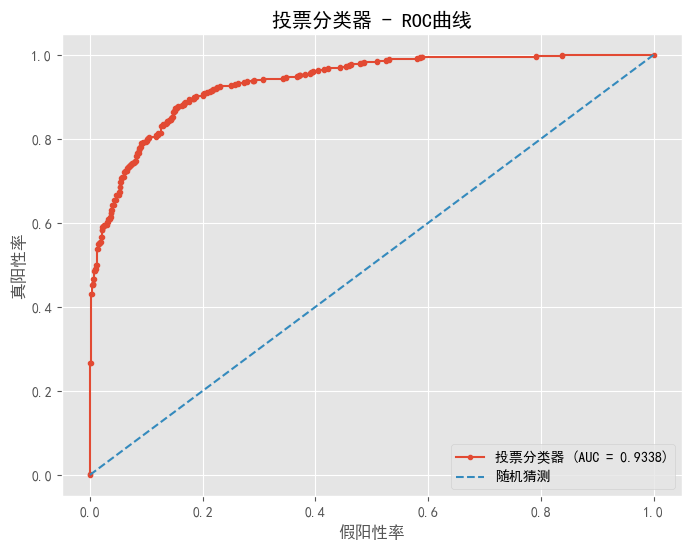

In [27]:
# 投票分类器模型
print("\n=============== 投票分类器 ===============")

# 使用最佳参数创建基础分类器
lr_best = LogisticRegression(**lr_grid.best_params_, max_iter=1000)
knn_best = KNeighborsClassifier(**knn_grid.best_params_)
svm_best = SVC(**svm_grid.best_params_, probability=True, random_state=42)
rf_best = RandomForestClassifier(**rf_grid.best_params_, random_state=42)

# 创建投票分类器
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_best),
        ('knn', knn_best),
        ('svm', svm_best),
        ('rf', rf_best)
    ],
    voting='soft'  # 使用预测概率
)

voting_results = evaluate_model(voting_clf, "投票分类器", X_train, X_test, y_train, y_test)


### AdaBoost分类器模型


=============== AdaBoost分类器 ===============

训练AdaBoost...

AdaBoost模型评估结果:
准确率: 0.8306
F1分数: 0.7888
AUC: 0.9022

混淆矩阵:
[[574  52]
 [137 353]]

分类报告:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       626
           1       0.87      0.72      0.79       490

    accuracy                           0.83      1116
   macro avg       0.84      0.82      0.82      1116
weighted avg       0.84      0.83      0.83      1116



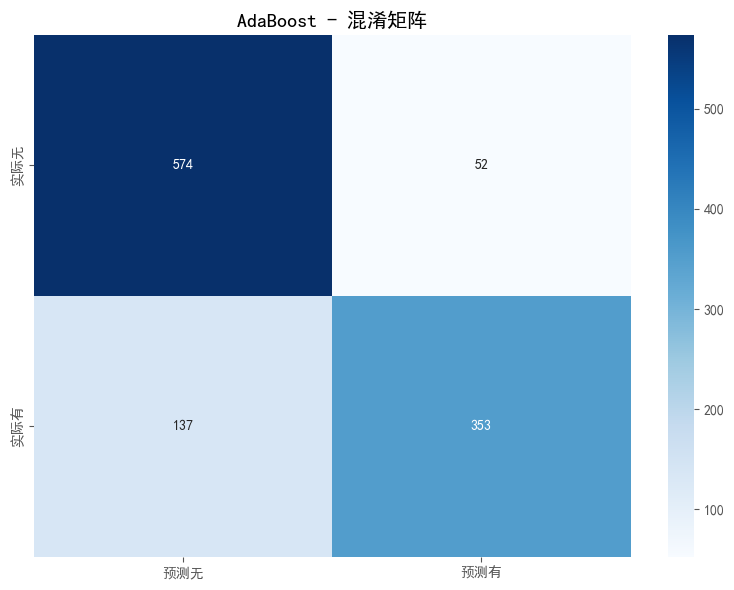

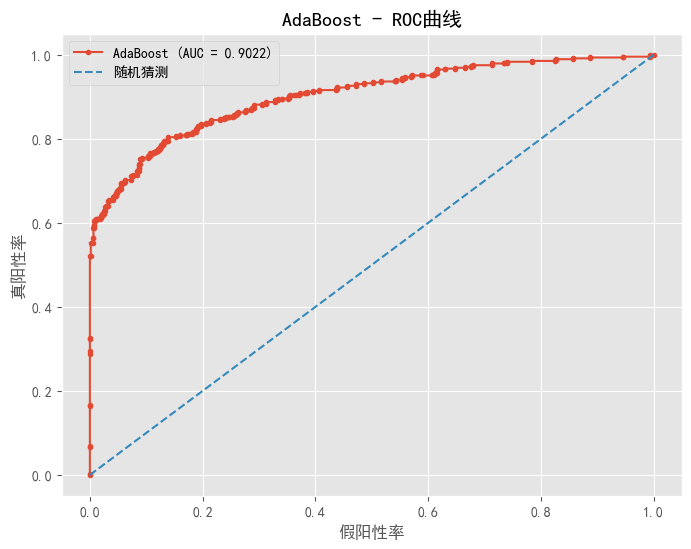

最佳参数: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}


In [28]:
# AdaBoost分类器模型
print("\n=============== AdaBoost分类器 ===============")
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}
base_estimator = DecisionTreeClassifier(max_depth=1)
ada_grid = GridSearchCV(
    AdaBoostClassifier(base_estimator=base_estimator, random_state=42),
    ada_params,
    cv=5,
    scoring='f1'
)
ada_results = evaluate_model(ada_grid, "AdaBoost", X_train, X_test, y_train, y_test)
print(f"最佳参数: {ada_grid.best_params_}")


### 梯度提升分类器模型


=============== 梯度提升分类器 ===============

训练梯度提升...

梯度提升模型评估结果:
准确率: 0.8862
F1分数: 0.8653
AUC: 0.9467

混淆矩阵:
[[581  45]
 [ 82 408]]

分类报告:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       626
           1       0.90      0.83      0.87       490

    accuracy                           0.89      1116
   macro avg       0.89      0.88      0.88      1116
weighted avg       0.89      0.89      0.89      1116



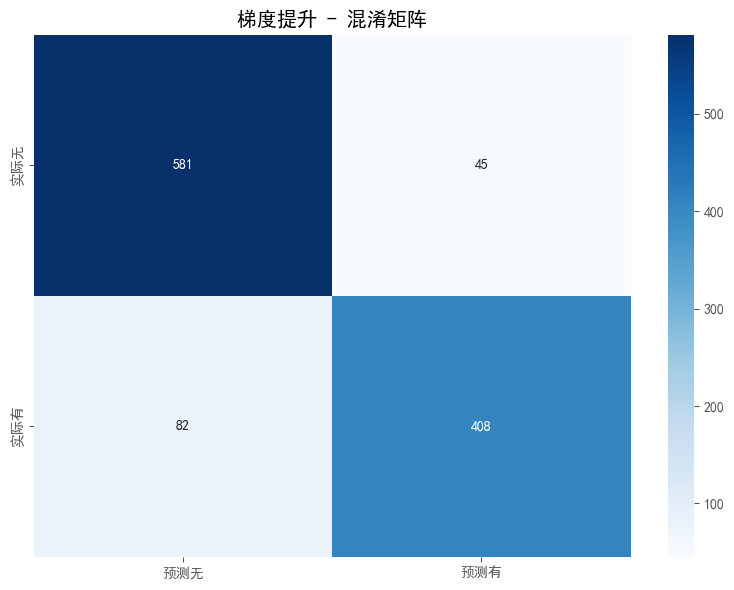

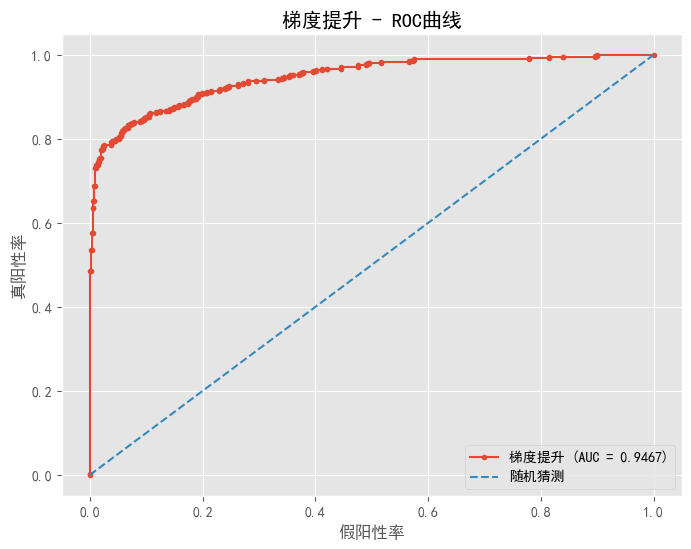

最佳参数: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [29]:
# 梯度提升分类器模型
print("\n=============== 梯度提升分类器 ===============")
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    cv=5,
    scoring='f1'
)
gb_results = evaluate_model(gb_grid, "梯度提升", X_train, X_test, y_train, y_test)
print(f"最佳参数: {gb_grid.best_params_}")


### XGBoost分类器模型


=============== XGBoost分类器 ===============

训练XGBoost...

XGBoost模型评估结果:
准确率: 0.8898
F1分数: 0.8701
AUC: 0.9437

混淆矩阵:
[[581  45]
 [ 78 412]]

分类报告:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       626
           1       0.90      0.84      0.87       490

    accuracy                           0.89      1116
   macro avg       0.89      0.88      0.89      1116
weighted avg       0.89      0.89      0.89      1116



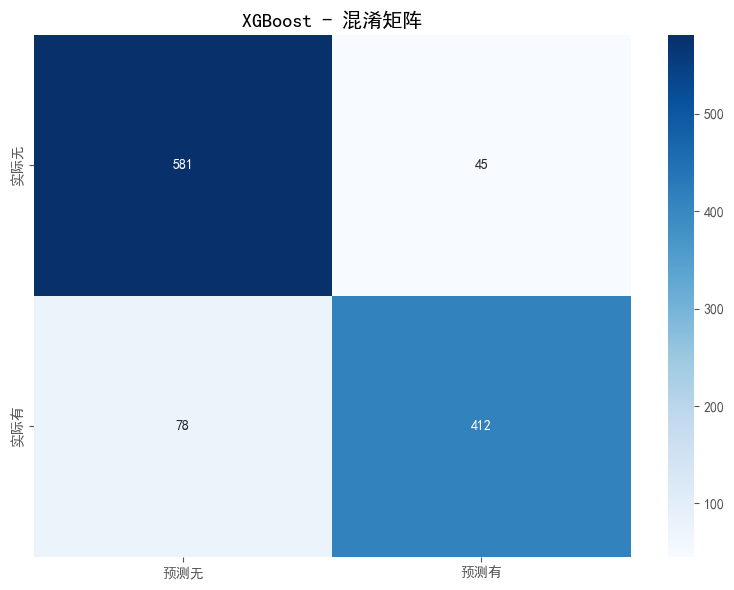

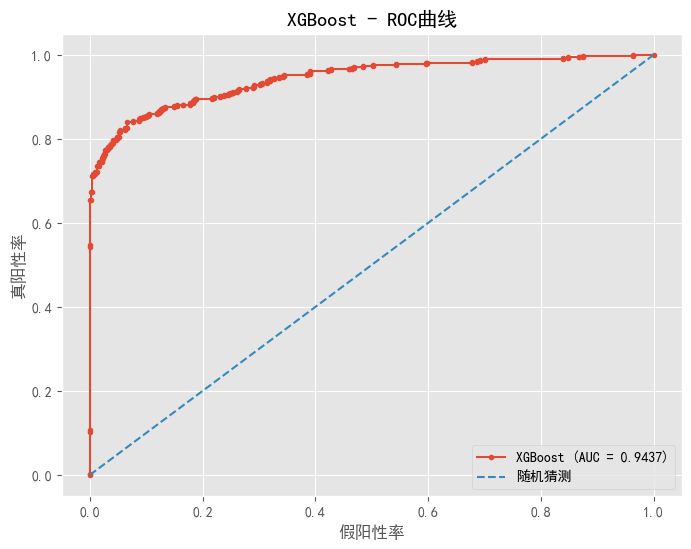

最佳参数: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [30]:
# XGBoost分类器模型
print("\n=============== XGBoost分类器 ===============")
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    xgb_params,
    cv=5,
    scoring='f1'
)
xgb_results = evaluate_model(xgb_grid, "XGBoost", X_train, X_test, y_train, y_test)
print(f"最佳参数: {xgb_grid.best_params_}")


### 堆叠分类器模型


=============== 堆叠分类器 ===============

训练堆叠分类器...

堆叠分类器模型评估结果:
准确率: 0.9122
F1分数: 0.8996
AUC: 0.9678

混淆矩阵:
[[579  47]
 [ 51 439]]

分类报告:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       626
           1       0.90      0.90      0.90       490

    accuracy                           0.91      1116
   macro avg       0.91      0.91      0.91      1116
weighted avg       0.91      0.91      0.91      1116



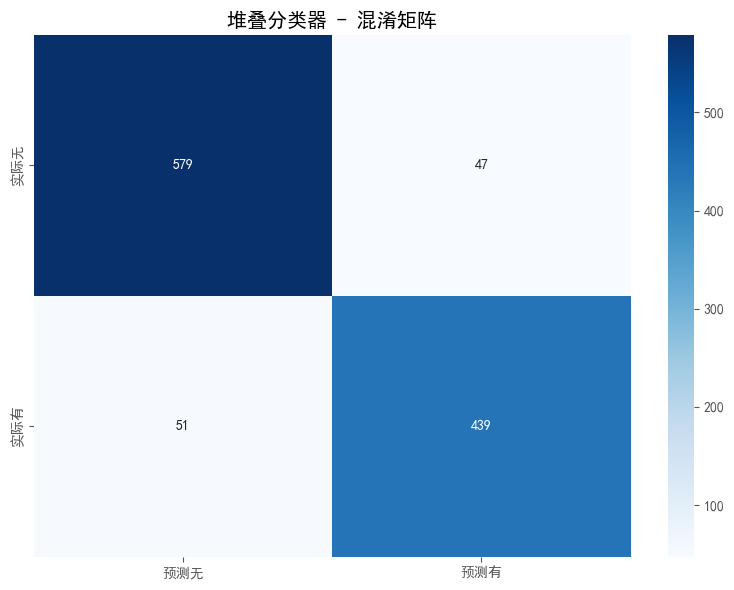

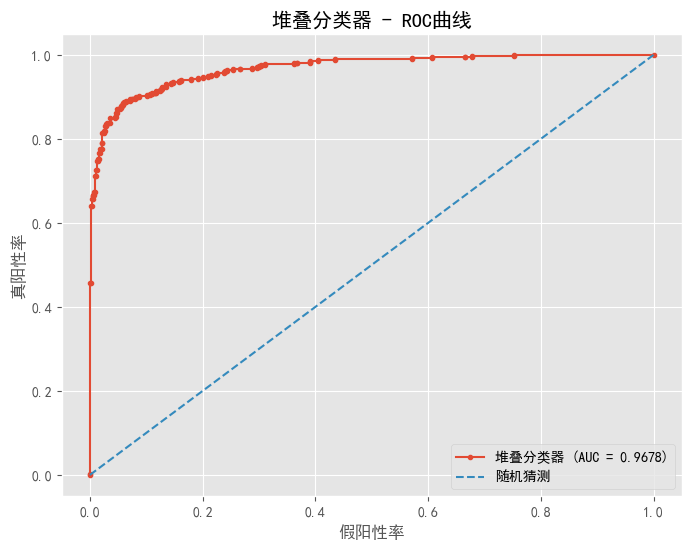

In [31]:
# 堆叠分类器模型
print("\n=============== 堆叠分类器 ===============")
# 定义基础分类器
estimators = [
    ('rf', RandomForestClassifier(**rf_grid.best_params_, random_state=42)),
    ('svm', SVC(**svm_grid.best_params_, probability=True, random_state=42)),
    ('gb', GradientBoostingClassifier(**gb_grid.best_params_, random_state=42))
]

# 创建堆叠分类器，使用逻辑回归作为最终分类器
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

stack_results = evaluate_model(stack_clf, "堆叠分类器", X_train, X_test, y_train, y_test)


### 集成模型比较


集成模型比较：
          accuracy        f1       auc
堆叠分类器     0.912186  0.899590  0.967777
梯度提升      0.886201  0.865323  0.946701
XGBoost   0.889785  0.870116  0.943705
投票分类器     0.858423  0.844488  0.933807
AdaBoost  0.830645  0.788827  0.902192


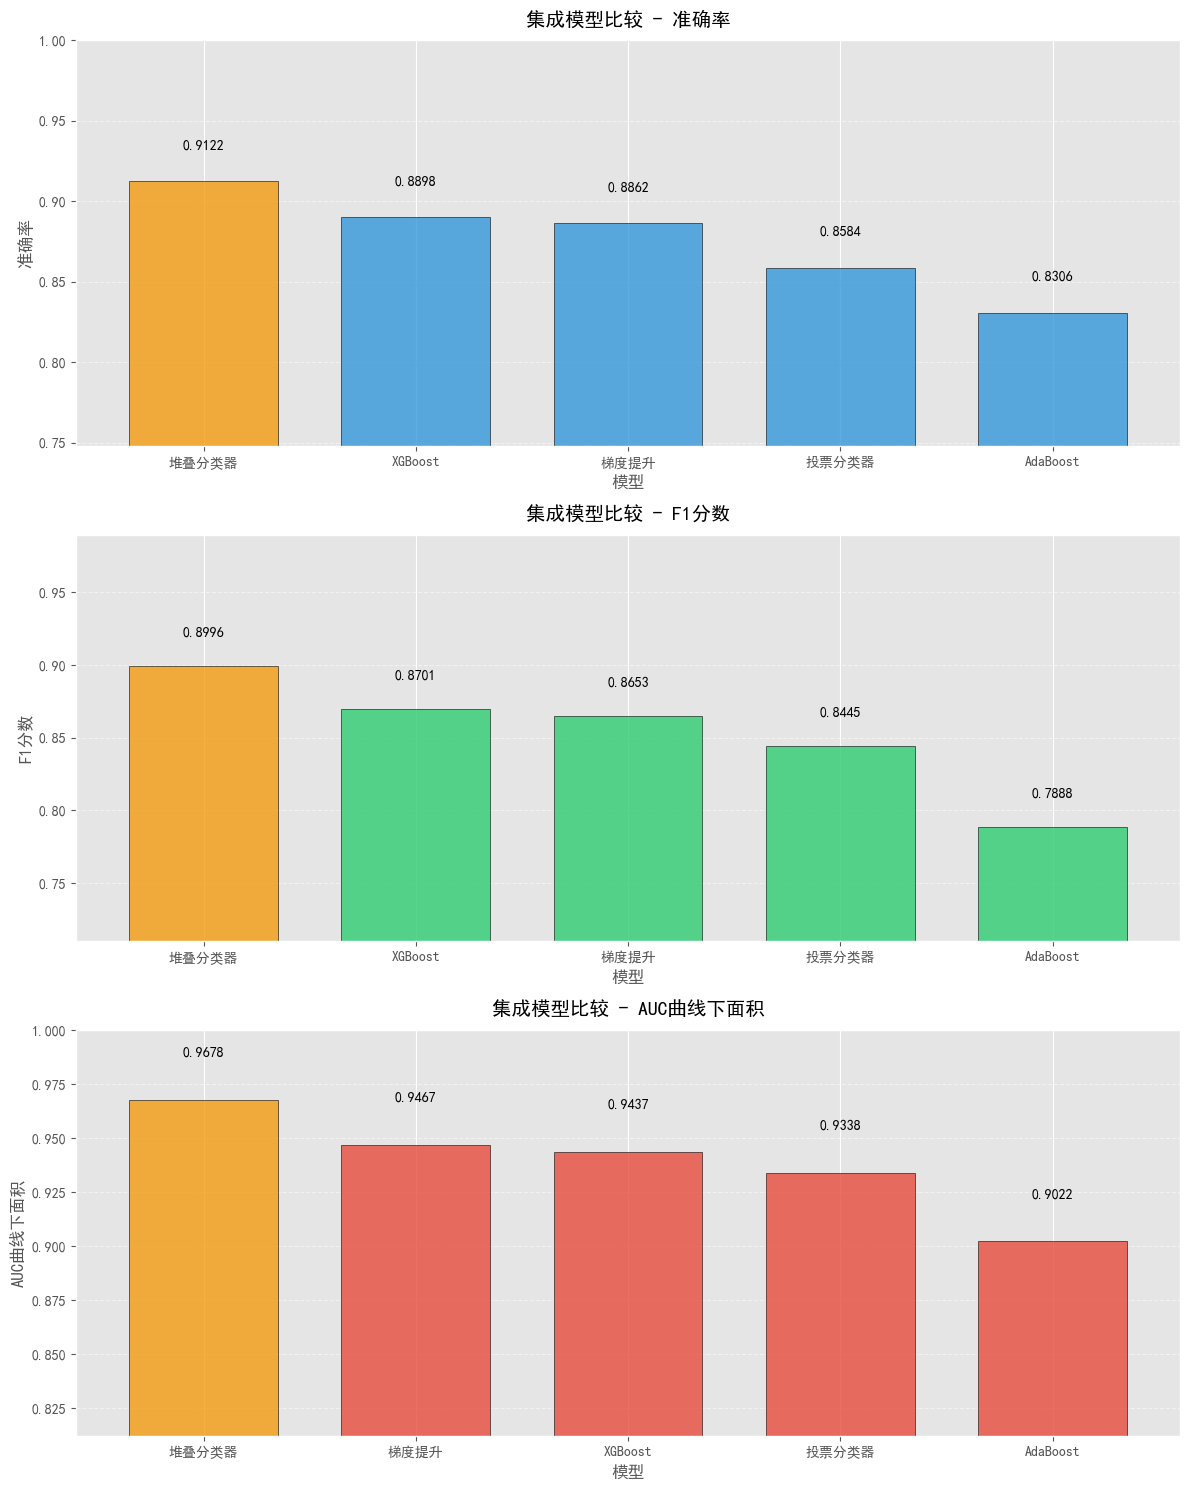

In [ ]:
# 绘制集成模型的ROC曲线比较
plt.figure(figsize=(12, 10))

# 设置颜色方案
color_dict = {
    "投票分类器": '#3498db',  # 蓝色
    "AdaBoost": '#2ecc71',    # 绿色
    "梯度提升": '#e74c3c',     # 红色
    "XGBoost": '#9b59b6',     # 紫色
    "堆叠分类器": '#f39c12'     # 橙色
}

# 绘制每个模型的ROC曲线
# 确保每个结果字典中有fpr和tpr键
if 'fpr' in voting_results and 'tpr' in voting_results:
    plt.plot(voting_results['fpr'], voting_results['tpr'], color=color_dict["投票分类器"], lw=2, 
             label=f'投票分类器 (AUC = {voting_results["auc"]:.4f})')

if 'fpr' in ada_results and 'tpr' in ada_results:
    plt.plot(ada_results['fpr'], ada_results['tpr'], color=color_dict["AdaBoost"], lw=2, 
             label=f'AdaBoost (AUC = {ada_results["auc"]:.4f})')

if 'fpr' in gb_results and 'tpr' in gb_results:
    plt.plot(gb_results['fpr'], gb_results['tpr'], color=color_dict["梯度提升"], lw=2, 
             label=f'梯度提升 (AUC = {gb_results["auc"]:.4f})')

if 'fpr' in xgb_results and 'tpr' in xgb_results:
    plt.plot(xgb_results['fpr'], xgb_results['tpr'], color=color_dict["XGBoost"], lw=2, 
             label=f'XGBoost (AUC = {xgb_results["auc"]:.4f})')

if 'fpr' in stack_results and 'tpr' in stack_results:
    plt.plot(stack_results['fpr'], stack_results['tpr'], color=color_dict["堆叠分类器"], lw=2, 
             label=f'堆叠分类器 (AUC = {stack_results["auc"]:.4f})')

# 添加对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 设置图表属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 (False Positive Rate)', fontsize=14)
plt.ylabel('真阳性率 (True Positive Rate)', fontsize=14)
plt.title('集成模型 ROC 曲线比较', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 在图上标出最佳模型的某个点
best_model = ensemble_df.index[0]  # 按AUC排序的第一个模型
if best_model == "堆叠分类器" and 'fpr' in stack_results and 'tpr' in stack_results:
    idx = np.argmax(stack_results['tpr'] - stack_results['fpr'])
    x, y = stack_results['fpr'][idx], stack_results['tpr'][idx]
    plt.plot(x, y, 'o', markersize=10, fillstyle='none', 
             c=color_dict[best_model], mew=2)
    plt.annotate(f'最佳平衡点', 
                xy=(x, y), xytext=(x+0.1, y-0.15),
                arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
                fontsize=12, color='black')

plt.tight_layout()
plt.show()


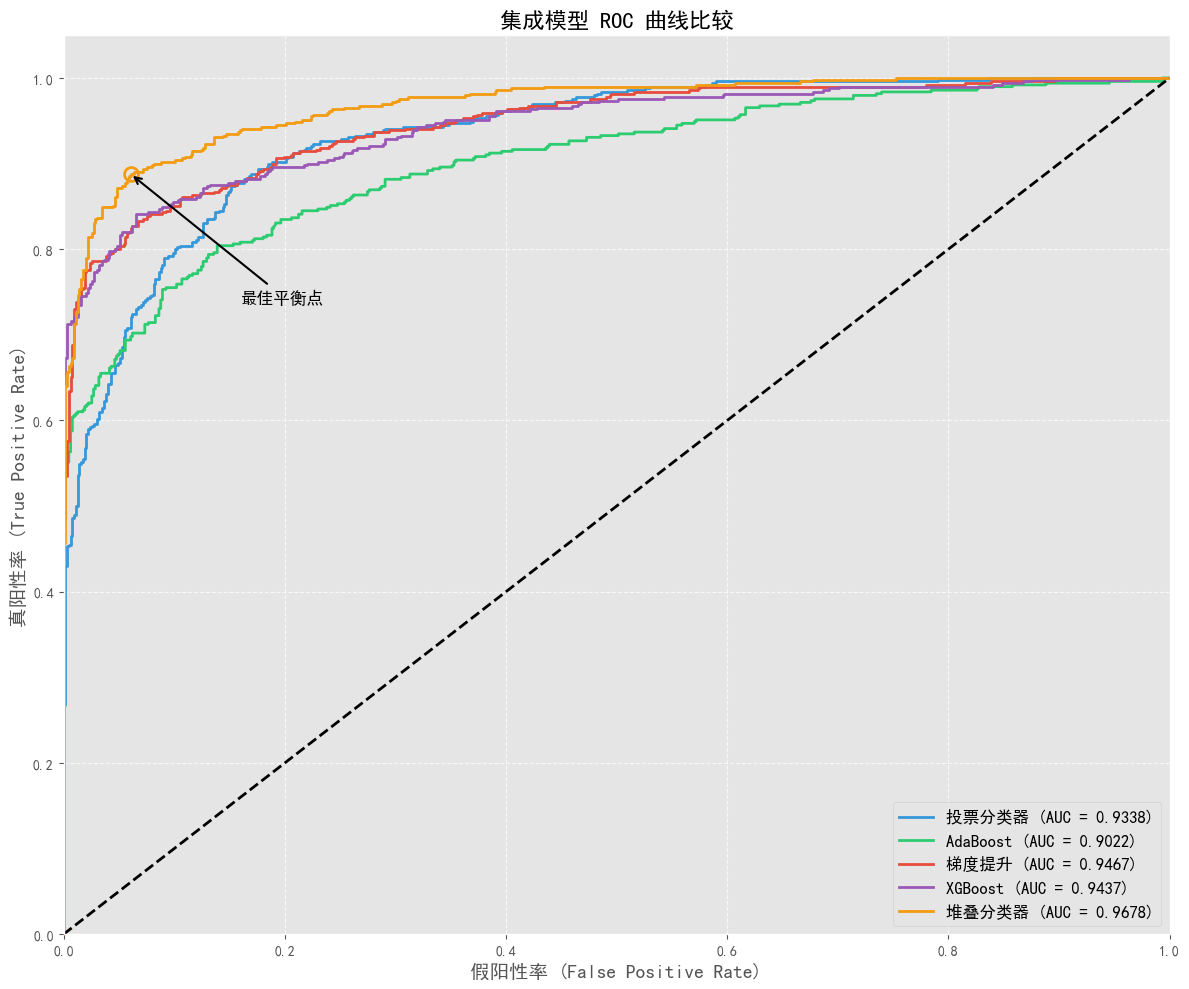

In [36]:
# 绘制集成模型的ROC曲线比较
plt.figure(figsize=(12, 10))

# 设置颜色方案
color_dict = {
    "投票分类器": '#3498db',  # 蓝色
    "AdaBoost": '#2ecc71',    # 绿色
    "梯度提升": '#e74c3c',     # 红色
    "XGBoost": '#9b59b6',     # 紫色
    "堆叠分类器": '#f39c12'     # 橙色
}

# 绘制每个模型的ROC曲线
# 确保每个结果字典中有fpr和tpr键
if 'fpr' in voting_results and 'tpr' in voting_results:
    plt.plot(voting_results['fpr'], voting_results['tpr'], color=color_dict["投票分类器"], lw=2, 
             label=f'投票分类器 (AUC = {voting_results["auc"]:.4f})')

if 'fpr' in ada_results and 'tpr' in ada_results:
    plt.plot(ada_results['fpr'], ada_results['tpr'], color=color_dict["AdaBoost"], lw=2, 
             label=f'AdaBoost (AUC = {ada_results["auc"]:.4f})')

if 'fpr' in gb_results and 'tpr' in gb_results:
    plt.plot(gb_results['fpr'], gb_results['tpr'], color=color_dict["梯度提升"], lw=2, 
             label=f'梯度提升 (AUC = {gb_results["auc"]:.4f})')

if 'fpr' in xgb_results and 'tpr' in xgb_results:
    plt.plot(xgb_results['fpr'], xgb_results['tpr'], color=color_dict["XGBoost"], lw=2, 
             label=f'XGBoost (AUC = {xgb_results["auc"]:.4f})')

if 'fpr' in stack_results and 'tpr' in stack_results:
    plt.plot(stack_results['fpr'], stack_results['tpr'], color=color_dict["堆叠分类器"], lw=2, 
             label=f'堆叠分类器 (AUC = {stack_results["auc"]:.4f})')

# 添加对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 设置图表属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 (False Positive Rate)', fontsize=14)
plt.ylabel('真阳性率 (True Positive Rate)', fontsize=14)
plt.title('集成模型 ROC 曲线比较', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 在图上标出最佳模型的某个点
best_model = ensemble_df.index[0]  # 按AUC排序的第一个模型
if best_model == "堆叠分类器" and 'fpr' in stack_results and 'tpr' in stack_results:
    idx = np.argmax(stack_results['tpr'] - stack_results['fpr'])
    x, y = stack_results['fpr'][idx], stack_results['tpr'][idx]
    plt.plot(x, y, 'o', markersize=10, fillstyle='none', 
             c=color_dict[best_model], mew=2)
    plt.annotate(f'最佳平衡点', 
                xy=(x, y), xytext=(x+0.1, y-0.15),
                arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
                fontsize=12, color='black')

plt.tight_layout()
plt.show()


### 多层感知机（MLP）模型

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.0



=============== 多层感知机（MLP）模型 ===============
Epoch 1/100
112/112 [==============================] - 2s 7ms/step - loss: 0.6758 - accuracy: 0.5847 - val_loss: 0.6333 - val_accuracy: 0.6607
Epoch 2/100
112/112 [==============================] - 0s 4ms/step - loss: 0.6465 - accuracy: 0.6262 - val_loss: 0.6211 - val_accuracy: 0.6685
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.6351 - val_loss: 0.6138 - val_accuracy: 0.6719
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.6634 - val_loss: 0.6034 - val_accuracy: 0.6820
Epoch 5/100
112/112 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.6721 - val_loss: 0.5969 - val_accuracy: 0.6920
Epoch 6/100
112/112 [==============================] - 0s 4ms/step - loss: 0.5994 - accuracy: 0.6701 - val_loss: 0.5942 - val_accuracy: 0.6820
Epoch 7/100
112/112 [==============================] - 0s 4ms/step - loss: 0.5943 - accuracy: 0.

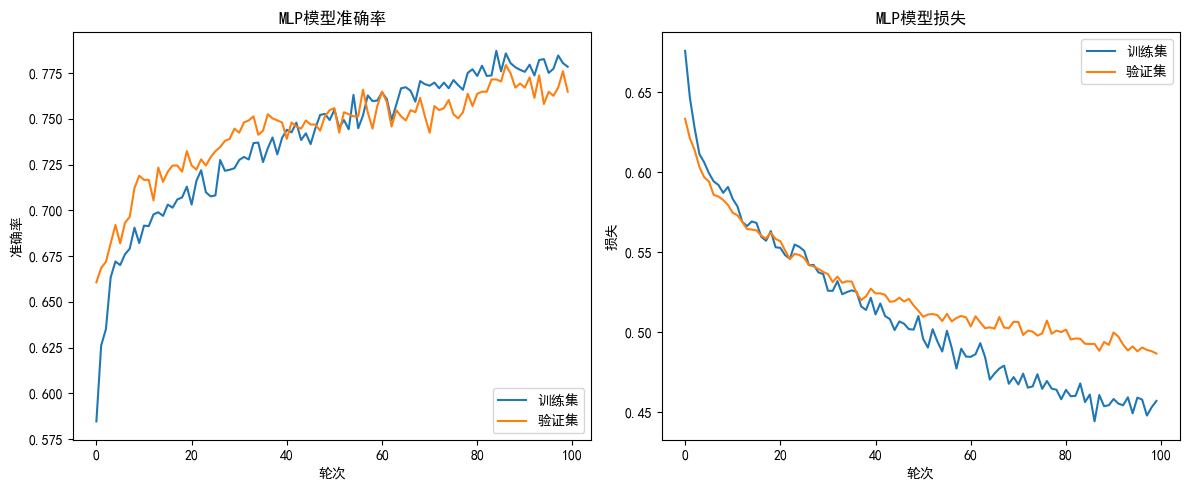

35/35 [==============================] - 0s 1ms/step
准确率: 0.7518
F1分数: 0.7374
AUC: 0.8446

混淆矩阵:
[[450 176]
 [101 389]]

分类报告:
              precision    recall  f1-score   support

           0       0.82      0.72      0.76       626
           1       0.69      0.79      0.74       490

    accuracy                           0.75      1116
   macro avg       0.75      0.76      0.75      1116
weighted avg       0.76      0.75      0.75      1116



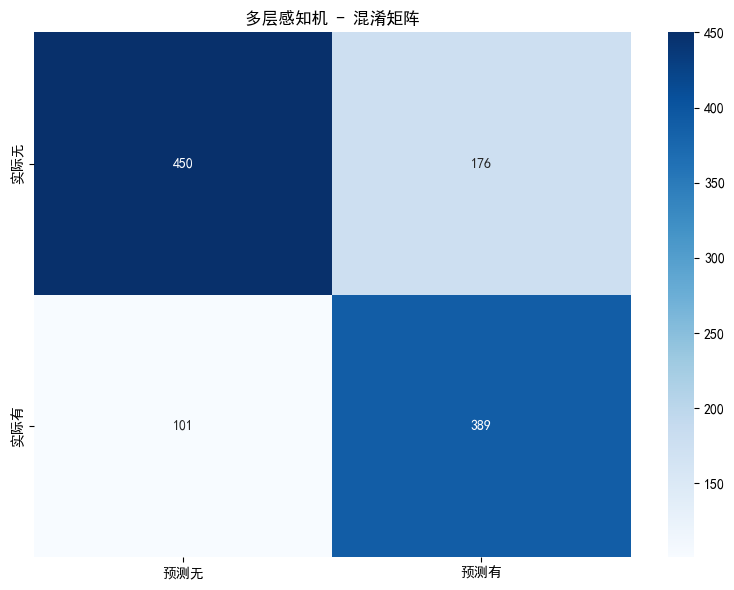

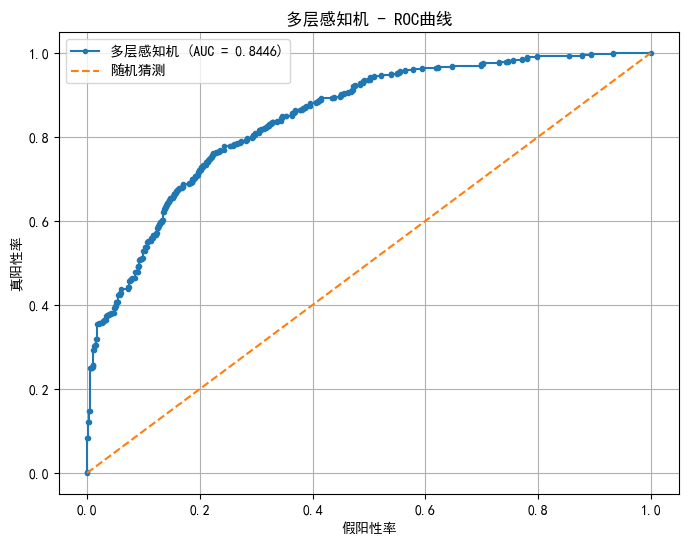

In [ ]:
# 导入TensorFlow和Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

print("\n=============== 多层感知机（MLP）模型 ===============")

# 将标签转换为独热编码格式
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# 构建MLP模型
def build_mlp_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 创建模型
mlp_model = build_mlp_model(X_train.shape[1])

# 设置早停以防止过拟合
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 训练模型
history = mlp_model.fit(
    X_train, y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 绘制训练历史
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP模型准确率')
plt.ylabel('准确率')
plt.xlabel('轮次')
plt.legend(['训练集', '验证集'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP模型损失')
plt.ylabel('损失')
plt.xlabel('轮次')
plt.legend(['训练集', '验证集'], loc='upper right')
plt.tight_layout()
plt.show()

# 评估模型
y_pred_proba = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)

# 计算评估指标
mlp_accuracy = accuracy_score(y_test_labels, y_pred)
mlp_f1 = f1_score(y_test_labels, y_pred)
mlp_auc = roc_auc_score(y_test_labels, y_pred_proba[:, 1])

print(f"准确率: {mlp_accuracy:.4f}")
print(f"F1分数: {mlp_f1:.4f}")
print(f"AUC: {mlp_auc:.4f}")

# 混淆矩阵
mlp_cm = confusion_matrix(y_test_labels, y_pred)
print("\n混淆矩阵:")
print(mlp_cm)

# 分类报告
print("\n分类报告:")
print(classification_report(y_test_labels, y_pred))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测无', '预测有'],
            yticklabels=['实际无', '实际有'])
plt.title('多层感知机 - 混淆矩阵')
plt.tight_layout()
plt.show()

# 绘制ROC曲线
mlp_fpr, mlp_tpr, _ = roc_curve(y_test_labels, y_pred_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(mlp_fpr, mlp_tpr, marker='.', label=f'多层感知机 (AUC = {mlp_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('多层感知机 - ROC曲线')
plt.legend()
plt.grid(True)
plt.show()

# 保存结果
mlp_results = {
    'accuracy': mlp_accuracy,
    'f1': mlp_f1,
    'auc': mlp_auc,
    'confusion_matrix': mlp_cm,
    'fpr': mlp_fpr,
    'tpr': mlp_tpr
}


### 卷积神经网络（CNN）模型


=============== 卷积神经网络（CNN）模型 ===============
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_

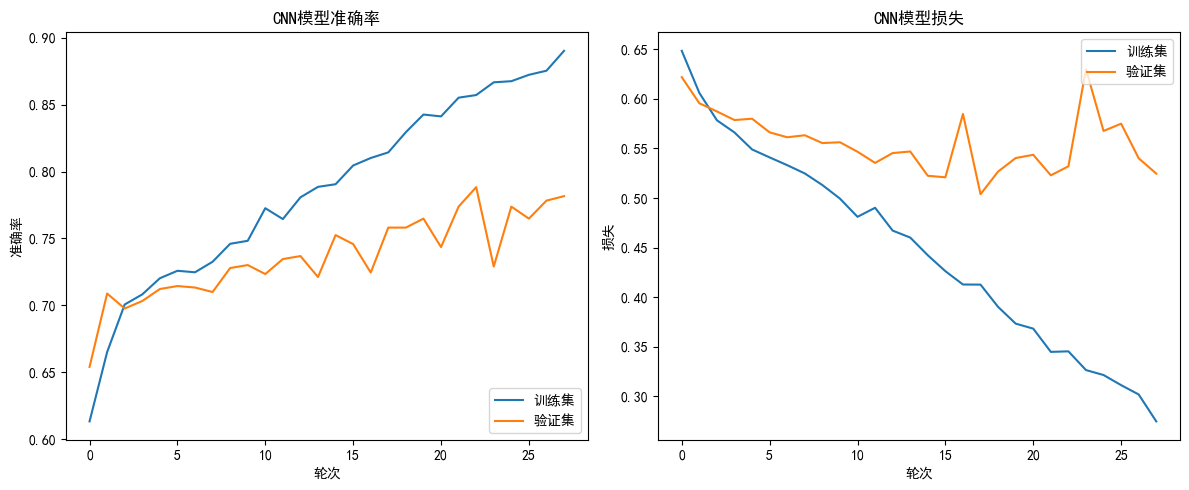

35/35 [==============================] - 0s 2ms/step
准确率: 0.7473
F1分数: 0.7202
AUC: 0.8302

混淆矩阵:
[[471 155]
 [127 363]]

分类报告:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       626
           1       0.70      0.74      0.72       490

    accuracy                           0.75      1116
   macro avg       0.74      0.75      0.74      1116
weighted avg       0.75      0.75      0.75      1116



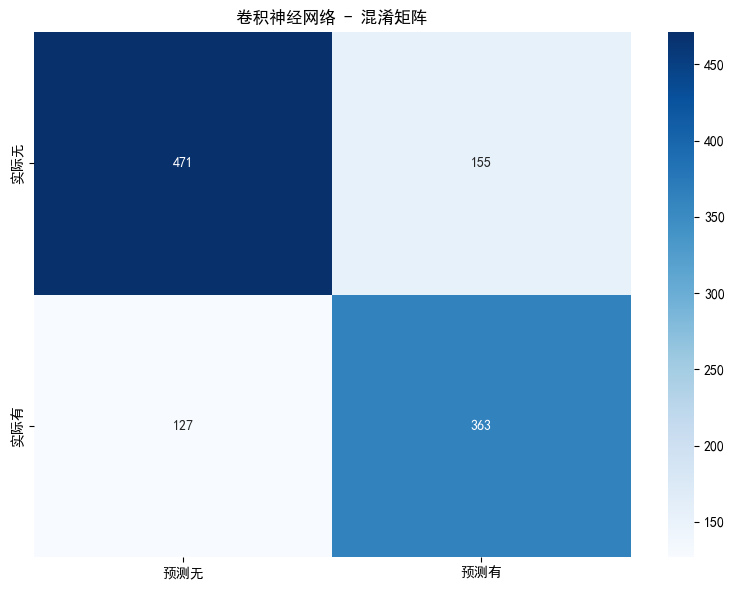

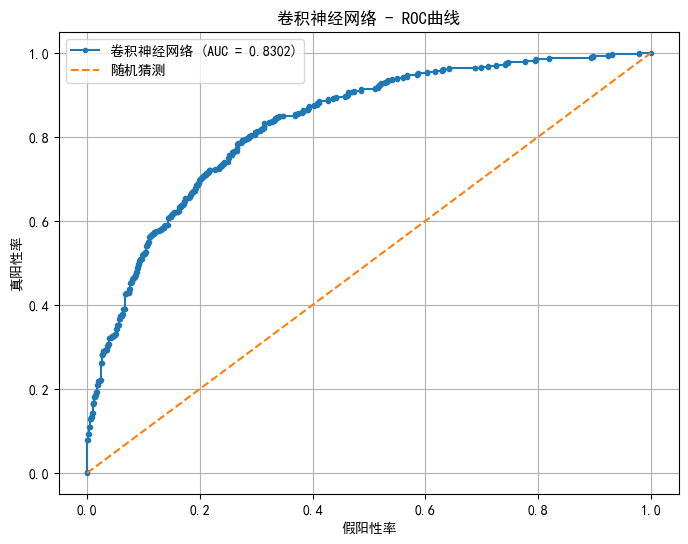

In [ ]:
# 卷积神经网络模型
print("\n=============== 卷积神经网络（CNN）模型 ===============")

# 重塑数据为CNN可以处理的格式
# 这里我们将1D特征转换成2D形式，使其可以应用于CNN
n_features = X_train.shape[1]
# 确定合适的reshape维度，将特征重塑为接近正方形的形状
side = int(np.ceil(np.sqrt(n_features)))
n_pad = side * side - n_features  # 需要填充的元素数量

# 对训练数据和测试数据重塑
X_train_reshaped = np.zeros((X_train.shape[0], side, side))
X_test_reshaped = np.zeros((X_test.shape[0], side, side))

for i in range(X_train.shape[0]):
    # 将原始特征填充并重塑为2D
    padded_features = np.pad(X_train.iloc[i].values, (0, n_pad), 'constant')
    X_train_reshaped[i] = padded_features.reshape(side, side)

for i in range(X_test.shape[0]):
    # 将原始特征填充并重塑为2D
    padded_features = np.pad(X_test.iloc[i].values, (0, n_pad), 'constant')
    X_test_reshaped[i] = padded_features.reshape(side, side)

# 增加通道维度，因为CNN需要输入形状为 (samples, height, width, channels)
X_train_reshaped = X_train_reshaped.reshape(X_train_reshaped.shape[0], side, side, 1)
X_test_reshaped = X_test_reshaped.reshape(X_test_reshaped.shape[0], side, side, 1)

# 构建CNN模型
def build_cnn_model(input_shape):
    model = Sequential([
        # 第一个卷积层
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # 第二个卷积层
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # 展平层
        tf.keras.layers.Flatten(),
        # 全连接层
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 创建CNN模型
cnn_model = build_cnn_model((side, side, 1))

# 打印模型摘要
cnn_model.summary()

# 训练模型
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 绘制训练历史
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('CNN模型准确率')
plt.ylabel('准确率')
plt.xlabel('轮次')
plt.legend(['训练集', '验证集'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN模型损失')
plt.ylabel('损失')
plt.xlabel('轮次')
plt.legend(['训练集', '验证集'], loc='upper right')
plt.tight_layout()
plt.show()

# 评估模型
y_pred_proba_cnn = cnn_model.predict(X_test_reshaped)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# 计算评估指标
cnn_accuracy = accuracy_score(y_test_labels, y_pred_cnn)
cnn_f1 = f1_score(y_test_labels, y_pred_cnn)
cnn_auc = roc_auc_score(y_test_labels, y_pred_proba_cnn[:, 1])

print(f"准确率: {cnn_accuracy:.4f}")
print(f"F1分数: {cnn_f1:.4f}")
print(f"AUC: {cnn_auc:.4f}")

# 混淆矩阵
cnn_cm = confusion_matrix(y_test_labels, y_pred_cnn)
print("\n混淆矩阵:")
print(cnn_cm)

# 分类报告
print("\n分类报告:")
print(classification_report(y_test_labels, y_pred_cnn))

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['预测无', '预测有'],
            yticklabels=['实际无', '实际有'])
plt.title('卷积神经网络 - 混淆矩阵')
plt.tight_layout()
plt.show()

# 绘制ROC曲线
cnn_fpr, cnn_tpr, _ = roc_curve(y_test_labels, y_pred_proba_cnn[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, marker='.', label=f'卷积神经网络 (AUC = {cnn_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='随机猜测')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('卷积神经网络 - ROC曲线')
plt.legend()
plt.grid(True)
plt.show()

# 保存结果
cnn_results = {
    'accuracy': cnn_accuracy,
    'f1': cnn_f1,
    'auc': cnn_auc,
    'confusion_matrix': cnn_cm,
    'fpr': cnn_fpr,
    'tpr': cnn_tpr
}


### 深度学习模型比较


深度学习模型比较：
        accuracy        f1       auc
多层感知机   0.751792  0.737441  0.844575
卷积神经网络  0.747312  0.720238  0.830237


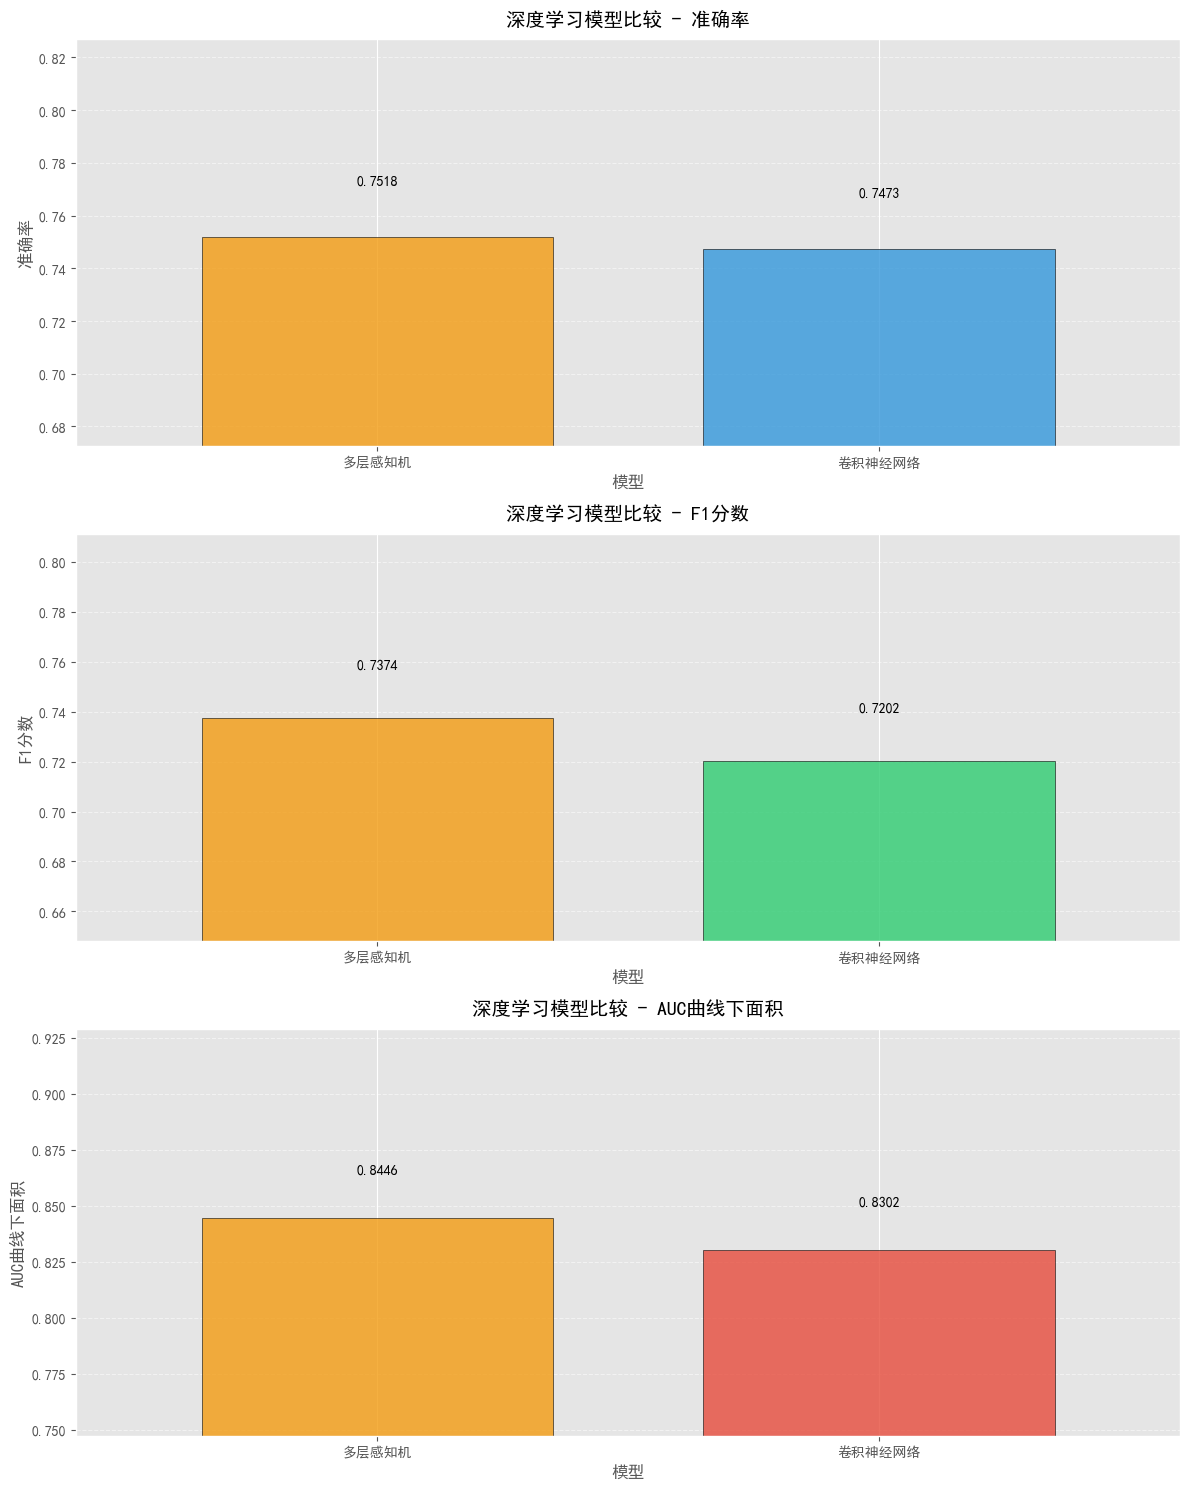

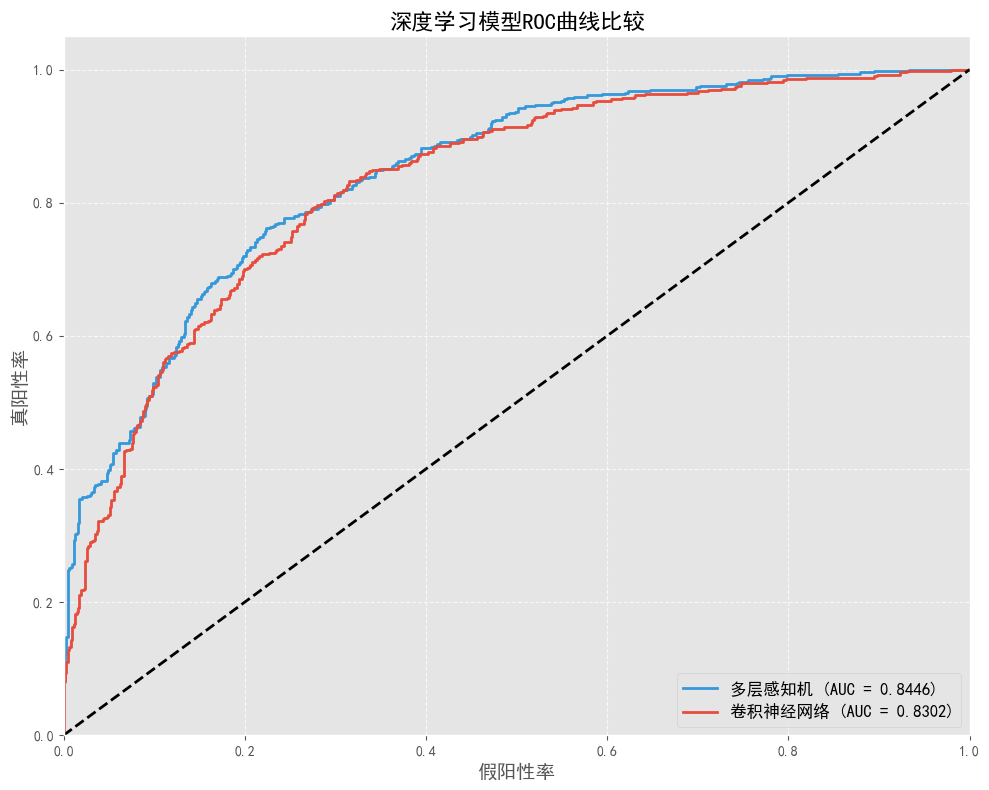

In [ ]:
# 深度学习模型性能比较
dl_results = {
    "多层感知机": {'accuracy': mlp_accuracy, 'f1': mlp_f1, 'auc': mlp_auc},
    "卷积神经网络": {'accuracy': cnn_accuracy, 'f1': cnn_f1, 'auc': cnn_auc}
}

# 创建比较DataFrame
dl_df = pd.DataFrame(dl_results).T
dl_df = dl_df.sort_values(by="auc", ascending=False)
print("\n深度学习模型比较：")
print(dl_df)

# 确保中文显示正常
import matplotlib as mpl
# 尝试设置中文字体，如果出错就使用英文标签
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
    use_chinese = True
except:
    use_chinese = False
    
# 可视化模型比较
plt.style.use('ggplot')  # 使用ggplot风格
metrics = ['accuracy', 'f1', 'auc']
metric_labels = {
    'accuracy': 'Accuracy (准确率)' if not use_chinese else '准确率',
    'f1': 'F1 Score (F1分数)' if not use_chinese else 'F1分数', 
    'auc': 'AUC' if not use_chinese else 'AUC曲线下面积'
}
model_title = 'Deep Learning Models Comparison' if not use_chinese else '深度学习模型比较'
colors = ['#3498db', '#2ecc71', '#e74c3c']  # 使用相同的颜色方案

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 15))

for i, metric in enumerate(metrics):
    # 按指标排序
    sorted_data = dl_df.sort_values(by=metric, ascending=False)
    
    # 创建柱状图
    bars = sorted_data[metric].plot(
        kind='bar', 
        ax=axes[i], 
        color=colors[i],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.8,
        width=0.7
    )
    
    # 设置标题和标签
    axes[i].set_title(f'{model_title} - {metric_labels[metric]}', fontsize=14, pad=10)
    axes[i].set_xlabel('Models (模型)' if not use_chinese else '模型', fontsize=12)
    axes[i].set_ylabel(metric_labels[metric], fontsize=12)
    
    # 设置y轴范围，使数据更突出
    y_min = max(0, min(sorted_data[metric]) * 0.9)
    y_max = min(1.0, max(sorted_data[metric]) * 1.1)
    axes[i].set_ylim(y_min, y_max)
    
    # 添加数值标签
    for j, v in enumerate(sorted_data[metric]):
        axes[i].text(
            j, 
            v + 0.02, 
            f'{v:.4f}', 
            ha='center',
            fontsize=10,
            fontweight='bold'
        )
    
    # 突出显示最佳模型
    best_model_idx = sorted_data[metric].idxmax()
    best_model_pos = sorted_data.index.get_loc(best_model_idx)
    bars.patches[best_model_pos].set_facecolor('#f39c12')  # 最佳模型用橙色
    
    # 改进网格线显示
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    
    # 旋转x轴标签使其更易读
    plt.setp(axes[i].get_xticklabels(), rotation=0, ha='center')

# 调整布局
plt.tight_layout()
plt.show()

# 绘制两个深度学习模型的ROC曲线比较
plt.figure(figsize=(10, 8))
plt.plot(mlp_fpr, mlp_tpr, color='#3498db', lw=2, 
         label=f'多层感知机 (AUC = {mlp_auc:.4f})')
plt.plot(cnn_fpr, cnn_tpr, color='#e74c3c', lw=2, 
         label=f'卷积神经网络 (AUC = {cnn_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率', fontsize=14)
plt.ylabel('真阳性率', fontsize=14)
plt.title('深度学习模型ROC曲线比较', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
